In [425]:
import numpy as np
import matplotlib.pyplot as plt
from beam_mechanics_3_script import simulate_beam, jacobian_tip_from_sim2, m_line_of_s
from constants import *
import types
from types import SimpleNamespace
from scipy.linalg import solve_discrete_are, solve_discrete_lyapunov, eigvals

Although this implmentation is quasi static, we define A and B matrices for implementation. 

In [2]:
def seq_mat(A, B, N):
    n, m = A.shape[0], B.shape[1]
    M = np.zeros((N*n,n))
    C = np.zeros((N*n, N*m))
    A_pow = np.eye(n)

    for i in range(1, N+1):
        A_pow = A@A_pow
        M[(i-1)*n:i*n,:] = A_pow
        
        for j in range(i):
            C[(i-1)*n: i*n, j*m:(j+1)*m] = np.linalg.matrix_power(A, i-1-j)@B
    return M,C 

Function for the block diagonal

In [3]:
def diag_bl(mat, times):
    r,c = mat.shape
    out = np.zeros((times*r, times*c))
    for i in range(times):
        out[i*r:(i+1)*r, i*c:(i+1)*c] = mat
    return out
    

Now build the mpc H and f matrices for quadratic programming

In [ ]:
def mpc_setup(A, B, Q, R, B_th, Qf, N, xk, xref_seq=None):
    n, m = A.shape[0], B.shape[1]
    M, C = seq_mat(A,B,N)

    Qtil = diag_bl(Q, N-1)

    Qtil = np.block([
        [Qtil, np.zeros(((N-1)*n,n))],
        [np.zeros((n, (N-1)*n)), Qf]
    ])

    Rtil = diag_bl(R, N)
    if xref_seq is None:
        Rvec = np.zeros(N*n)
    else:
        Rvec = xref_seq.reshape(N*n)


    H = 2*(C.T@Qtil@C+Rtil)
    F = 2*  C.T@Qtil@(M@xk-Rvec)

    try:
        U_star = -np.linalg.solve(H,F)
    except np.linalg.LinAlgError:
        U_star = -np.linalg.lstsq(H,F, rcond=None)[0]
    X_pred = M@xk+C@U_star
    u0 = U_star[:m]
    E = np.linalg.solve(H, 2 * (C.T @ Qtil))        
    L = float(-(E[0, :] @ M))                        
    lam_cl = 1.0 + float(B_th[0,0]) * L               # eigenvalue of A + B L (since A=1)
    print(f"L={L:+.6f},  lambda_cl={lam_cl:+.6f}")


    return u0, U_star, X_pred, H, F, M, C, Qtil

    


In [5]:
# def mpc_setup(A, B, Q, R, Qf, N, xk, xref_seq=None):
#     n, m = A.shape[0], B.shape[1]
#     M, C = seq_mat(A,B,N)

#     Qtil = diag_bl(Q, N-1)

#     Qtil = np.block([
#         [Qtil, np.zeros(((N-1)*n,n))],
#         [np.zeros((n, (N-1)*n)), Qf]
#     ])

#     Rtil = diag_bl(R, N)
#     if xref_seq is None:
#         Rvec = np.zeros(N*n)
#     else:
#         Rvec = xref_seq.reshape(N*n)


#     # exact predicted tracking (unconstrained, scalar integrator)
#     d = Rvec - (M @ xk)          # shape [N]
#     U_star = np.linalg.solve(C, d)  # since C = b*S is lower-triangular and invertible
#     X_pred = M @ xk + C @ U_star
#     u0 = U_star[:B.shape[1]]
#     H, F = None, None  # not used in this mode
#     return u0, U_star, X_pred, H, F, M, C, Qtil


    


The main MPC function will be implemented below. This function will be simple and provide a base MPC

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def print_rollout_table(k, t, dt, psi_k, u_star, S, theta_pred, R_vec):
    u_deg_s       = np.degrees(u_star)
    dpsi_deg      = np.degrees(S @ u_star)                 # cumulative Δψ
    psi_pred_deg  = np.degrees(psi_k + S @ u_star)
    theta_pred_deg= np.degrees(theta_pred)
    R_deg         = np.degrees(R_vec)
    err_deg       = theta_pred_deg - R_deg

    header = (f"\n[Rollout] k={k}  t={t:.3f}s  ψ_k={np.degrees(psi_k):+.2f}°  "
              f"max|Δψ|={np.max(np.abs(dpsi_deg)):.2f}°  max|θ̂-R|={np.max(np.abs(err_deg)):.2f}°")
    print(header)
    print(" i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]")
    print("-"*86)
    for i in range(len(u_star)):
        print(f"{i+1:2d} | {u_deg_s[i]:+12.2f} | {dpsi_deg[i]:+12.2f} |"
              f" {psi_pred_deg[i]:+11.2f} | {theta_pred_deg[i]:+11.2f} |"
              f" {R_deg[i]:+11.2f} | {err_deg[i]:+13.2f}")

In [7]:
def simple_mpc(ref, T, dt, p_vec, *, Np = 15, w_th=1.0, w_u=1e-3, psi0_rad=0.0, J_min=1e-5, s_steps=200):
    
    t_hist, th_hist, thref_hist, psi_hist, u_hist, J_hist = [], [], [], [], [], []
    pred_theta_hist_deg, pred_psi_hist_deg = [], []
    pred_ref_hist_deg,   pred_u_hist_deg_s = [], []
    e1_hist_deg = []
    psi = psi0_rad


    N = int(T/dt)
    for k in range(N):
        t = k*dt
        theta0, k_star, sol_ivp, info = simulate_beam(p_vec, np.rad2deg(psi), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        sim = {"theta_tip": theta0, "sol_ivp": sol_ivp, "info": info}
        theta_tip, J0, pack = jacobian_tip_from_sim2(
            p_vec, psi,
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, GRAD_SCALE=1.0, s_steps=400,
            sim=sim,              
        )

        R_vec = np.array([ref(t+(i+1)*dt)[0] for i in range(Np)],dtype=float)
        A_th = np.array([[1.0]])
        B_th = np.array([[J0*dt]])
        Q_th = np.array([[w_th]])
        R_u = np.array([[w_u]])
        Qf_th = Q_th

        xk_th = np.array([theta0])
        xref_seq = R_vec.reshape(Np,1)

        u0, U_star, X_pred, H, F, M, C, Qtil = mpc_setup(A_th, B_th, Q_th, R_u, B_th, Qf_th, Np, xk_th, xref_seq)
        # assert np.allclose(X_pred.reshape(Np), R_vec, atol=1e-10), "Predicted != reference"

        u_apply = float(u0)
        psi_next = psi + u_apply*dt

        theta_pred = X_pred.reshape(Np)
        theta_next,_,_,_ = simulate_beam(p_vec, np.rad2deg(psi_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val)
        e1_hist_deg.append(np.degrees(theta_next-theta_pred[0]))

        S = np.tril(np.ones((Np, Np), float)) * dt
        psi_pred = psi + S @ U_star.reshape(-1)
        print_rollout_table(k, t, dt, psi, U_star.reshape(-1), S, theta_pred, R_vec)
        # print(
        # # f"step={k} | J0={J0:.3e} | ||H||={np.linalg.norm(H):.3e} "
        # f"| ||F||={np.linalg.norm(F):.3e} | ||U*||={np.linalg.norm(U_star):.3e}"
        # )
        lam_min = np.linalg.eigvalsh(C.T @ Qtil @ C).min()
        rho = w_u / lam_min
        print(f"lam_min(C^T Q C)={lam_min:.2e}  rho={rho:.2e}")

        pred_theta_hist_deg.append(np.degrees(theta_pred))
        pred_psi_hist_deg.append(np.degrees(psi_pred))
        pred_ref_hist_deg.append(np.degrees(R_vec))
        pred_u_hist_deg_s.append(np.degrees(U_star.reshape(-1)))

        psi = psi_next

        t_hist.append(t)
        th_hist.append(theta0)
        thref_hist.append(ref(t)[0]) 
        psi_hist.append(psi)
        u_hist.append(u_apply)
        J_hist.append(J0)
    t    = np.array(t_hist)
    th   = np.degrees(np.array(th_hist))
    thR  = np.degrees(np.array(thref_hist))
    psiA = np.degrees(np.array(psi_hist))
    uA   = np.degrees(np.array(u_hist))
    Jarr = np.array(J_hist)
    e1d  = np.array(e1_hist_deg)
    rmse1_deg = float(np.sqrt(np.mean(e1d**2))) if len(e1d) else float("nan")
    
    return dict(
    t=t, theta_deg=th, theta_ref_deg=thR, psi_deg=psiA, u_deg_s=uA, J=Jarr,
    pred_theta_deg=np.array(pred_theta_hist_deg),
    pred_psi_deg=np.array(pred_psi_hist_deg),
    pred_ref_deg=np.array(pred_ref_hist_deg),
    pred_u_deg_s=np.array(pred_u_hist_deg_s),
    e1_deg=e1d, rmse1_deg=rmse1_deg, Np=Np, dt=dt
)     



In [4]:
def make_ref_sine(Amp, freq, offset, phase):
    w = 2*np.pi*freq
    return lambda t:(offset + Amp*-1*np.sin(w*t+phase), Amp*w*np.cos(w*t+phase)) 

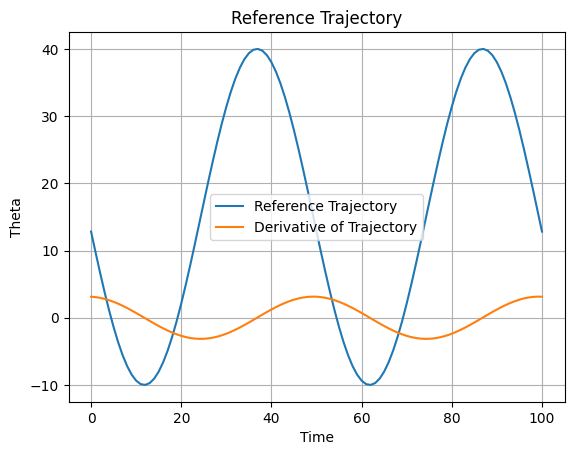

In [6]:
amp = np.deg2rad(25)
freq = 0.02
offset = np.deg2rad(15)
phase = np.deg2rad(5)
time = 100
dt = 1
ref = make_ref_sine(amp, freq, offset, phase)

t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [276]:
psi_vals_deg = np.linspace(-90, 90, 100)
psi_vals_rad = np.deg2rad(psi_vals_deg)

ys = np.array([0.18])
theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done_s = {py: [] for py in ys}

for p_y in ys:
    p_vec = np.array([LENGTH, p_y, 0.0], float)
    for psi_deg in psi_vals_deg:
        try:
            theta_tip, k_star, sol_ivp, info = simulate_beam(
                p_vec=p_vec,
                psi_deg=psi_deg,
                L=LENGTH,
                A_val=A_val,  
                E_val=E_val,
                I_val=I_val,
                MU0=MU0,
                MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_deg:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        psi_done_s[p_y].append(psi_deg)

    print(f"p_y={p_y}: filled {len(psi_done_s[p_y])}/{len(psi_vals_deg)} points")



p_y=0.18: filled 100/100 points


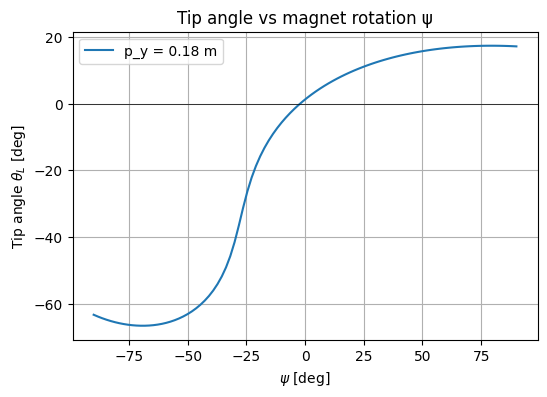

In [278]:
plt.figure(figsize=(6,4))
for p_y in ys:
    plt.plot(psi_vals_deg, theta_vs_psi[p_y], label=f"p_y = {p_y} m")
plt.axhline(0, color='k', lw=0.5)
plt.xlabel(r"$\psi$ [deg]")
plt.ylabel(r"Tip angle $\theta_L$ [deg]")
plt.legend()
plt.title("Tip angle vs magnet rotation ψ")
plt.grid(True)
plt.show()


In [259]:
from scipy.interpolate import PchipInterpolator

def build_theta_interp_rad(psi_rad_samples, theta_deg_samples, *, extrapolate=False, clamp=True):
    # ψ in rad, θ in deg (from your sim)
    x = np.asarray(psi_rad_samples, float)
    y = np.deg2rad(np.asarray(theta_deg_samples, float))  # convert θ->rad

    # sort & dedupe ψ
    order = np.argsort(x)
    x = x[order]; y = y[order]
    x, idx = np.unique(x, return_index=True)
    y = y[idx]

    f = PchipInterpolator(x, y, extrapolate=extrapolate)  # θ(rad) vs ψ(rad)

    x_min, x_max = float(x[0]), float(x[-1])

    def theta_of_psi_rad(psi):
        psi = np.asarray(psi, float)
        if clamp:
            psi = np.clip(psi, x_min, x_max)
        return f(psi)  # θ in radians

    return theta_of_psi_rad, (x_min, x_max)

In [293]:

# psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.linspace(-3,3,100)
# ys = np.array([0.18])   
ys = np.array([0.18])

theta_vs_psi_j = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done_j = {py: [] for py in ys}
packs = {py: [] for py in ys} 

for p_y in ys:
    p_vec = np.array([LENGTH, p_y, 0.0], float)
    for psi_rad in psi_vals_rad:
        # psi_rad = np.deg2rad(psi_deg)
        try:
            theta_tip, J_tip, pack = jacobian_tip_from_sim2(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                GRAD_SCALE=1.0, s_steps=400
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_rad:.1f}: {e}")
            continue

        theta_vs_psi_j[p_y].append(np.degrees(theta_tip))
        dtheta_dpsi_vs_psi[p_y].append(J_tip)            
        psi_done_j[p_y].append(psi_rad)
        packs[p_y].append(pack)

    print(f"p_y={p_y}: filled {len(psi_done_j[p_y])}/{len(psi_vals_rad)} points")


p_y=0.18: filled 100/100 points


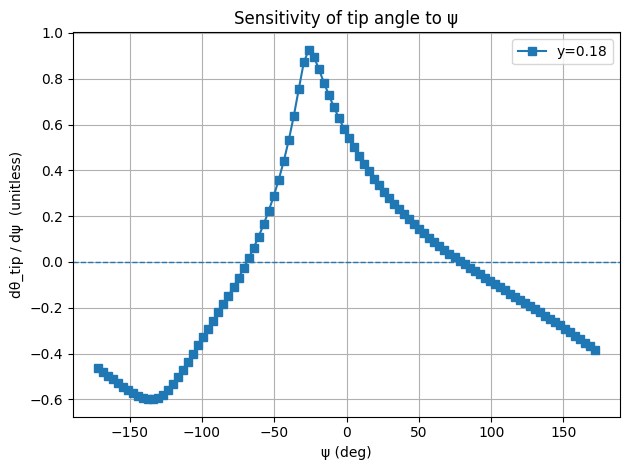

In [294]:
plt.figure()
for p_y in ys:                         
    ps = np.array(psi_done_j[p_y])
    J  = np.array(dtheta_dpsi_vs_psi[p_y])
    order = np.argsort(ps)
    plt.plot(np.degrees(ps[order]),          
             J[order], marker='s', label=f"y={p_y:.2f}")
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel("ψ (deg)")                    
plt.ylabel("dθ_tip / dψ  (unitless)")
plt.title("Sensitivity of tip angle to ψ")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


ψ=-90.0° | θ_fit=-63.277° | θ_true=-63.277° | J_fit=-0.2352 | J_true=-0.2352
ψ=-70.0° | θ_fit=-66.566° | θ_true=-66.566° | J_fit=-0.0135 | J_true=-0.0135
ψ=-50.0° | θ_fit=-63.077° | θ_true=-63.077° | J_fit= 0.2941 | J_true= 0.2941
ψ=-30.0° | θ_fit=-41.517° | θ_true=-41.517° | J_fit= 0.8604 | J_true= 0.8577
ψ=-10.0° | θ_fit= -5.680° | θ_true= -5.680° | J_fit= 0.6950 | J_true= 0.6949
ψ= 10.0° | θ_fit=  6.076° | θ_true=  6.076° | J_fit= 0.4498 | J_true= 0.4498
ψ= 30.0° | θ_fit= 12.317° | θ_true= 12.317° | J_fit= 0.2764 | J_true= 0.2764
ψ= 50.0° | θ_fit= 15.725° | θ_true= 15.725° | J_fit= 0.1461 | J_true= 0.1461
ψ= 70.0° | θ_fit= 17.204° | θ_true= 17.204° | J_fit= 0.0422 | J_true= 0.0422


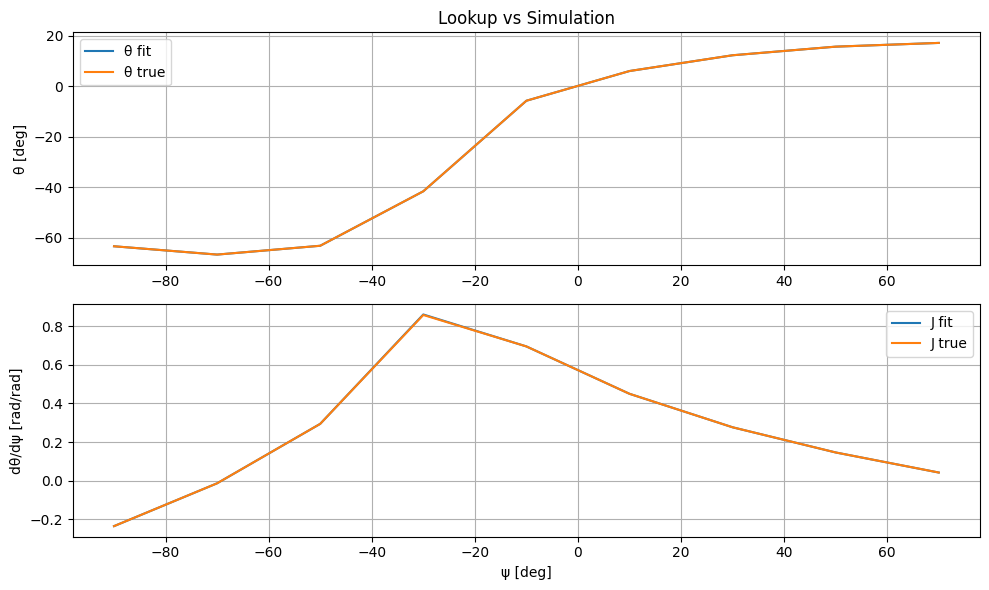

In [ ]:
# --- builders ---
from scipy.interpolate import PchipInterpolator
import numpy as np
import matplotlib.pyplot as plt

def build_theta_interp_rad(psi_rad_samples, theta_deg_samples, *, extrapolate=False, clamp=True):
    x = np.asarray(psi_rad_samples, float)
    y = np.deg2rad(np.asarray(theta_deg_samples, float)) 
    order = np.argsort(x); x = x[order]; y = y[order]
    x, idx = np.unique(x, return_index=True); y = y[idx]
    f = PchipInterpolator(x, y, extrapolate=extrapolate)  
    x_min, x_max = float(x[0]), float(x[-1])

    def theta_of_psi_rad(psi):
        psi = np.asarray(psi, float)
        if clamp: psi = np.clip(psi, x_min, x_max)
        return f(psi)                                  
    return theta_of_psi_rad, (x_min, x_max)

def build_scalar_interp_rad(psi_rad_samples, y_samples, *, extrapolate=False, clamp=True):
    x = np.asarray(psi_rad_samples, float)
    y = np.asarray(y_samples, float)
    order = np.argsort(x); x = x[order]; y = y[order]
    x, idx = np.unique(x, return_index=True); y = y[idx]
    f = PchipInterpolator(x, y, extrapolate=extrapolate)
    x_min, x_max = float(x[0]), float(x[-1])

    def y_of_psi_rad(psi):
        psi = np.asarray(psi, float)
        if clamp: psi = np.clip(psi, x_min, x_max)
        return f(psi)
    return y_of_psi_rad, (x_min, x_max)

p_y = 0.18
p_vec = np.array([LENGTH, p_y, 0.0])

psi_rad_samples_j = np.array(psi_done_j[p_y], float)     
psi_rad_samples_s = np.array(psi_done_s[p_y], float)        

theta_deg_samples = np.array(theta_vs_psi[p_y], float)        
J_samples         = np.array(dtheta_dpsi_vs_psi[p_y], float)

theta_fn, (psi_min_s, psi_max_s) = build_theta_interp_rad(psi_rad_samples_s, theta_deg_samples)
J_fn,     (psi_min_j, psi_max_j) = build_scalar_interp_rad(psi_rad_samples_j, J_samples)

psi_min = max(psi_min_s, psi_min_j)
psi_max = min(psi_max_s, psi_max_j)

theta_test_values, jac_test_values = [], []
theta_actual_values, jac_actual_values = [], []
test_values_deg = np.arange(-90, 90, 20)

for test_deg in test_values_deg:
    psi_q_rad = np.deg2rad(test_deg)                         

    if not (psi_min <= psi_q_rad <= psi_max):
        continue

    theta_q = float(theta_fn(test_deg))              
    jac_q   = float(J_fn(psi_q_rad))   
    jac_q = jac_q                      

    theta_tip, k_star, sol_ivp, info = simulate_beam(
        p_vec=p_vec,
        psi_deg=test_deg,
        L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        s_steps=200
    )
    _, J_tip, _ = jacobian_tip_from_sim2(
        p_vec, psi_q_rad, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        GRAD_SCALE=1.0, s_steps=400
    )

    print(f"ψ={test_deg:>5.1f}° | θ_fit={np.degrees(theta_q):7.3f}° "
          f"| θ_true={np.degrees(theta_tip):7.3f}° | J_fit={jac_q:7.4f} | J_true={J_tip:7.4f}")

    theta_test_values.append(np.degrees(theta_q))
    jac_test_values.append(jac_q)
    theta_actual_values.append(np.degrees(theta_tip))
    jac_actual_values.append(J_tip)

test_values_deg = np.array(test_values_deg[:len(theta_test_values)], float)
theta_test_values   = np.array(theta_test_values, float)
theta_actual_values = np.array(theta_actual_values, float)
jac_test_values     = np.array(jac_test_values, float)
jac_actual_values   = np.array(jac_actual_values, float)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(test_values_deg, theta_test_values,   label="θ fit")
plt.plot(test_values_deg, theta_actual_values, label="θ true")
plt.ylabel("θ [deg]"); plt.title("Lookup vs Simulation"); plt.grid(True); plt.legend()

plt.subplot(2,1,2)
plt.plot(test_values_deg, jac_test_values,   label="J fit")
plt.plot(test_values_deg, jac_actual_values, label="J true")
plt.xlabel("ψ [deg]"); plt.ylabel("dθ/dψ [rad/rad]"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


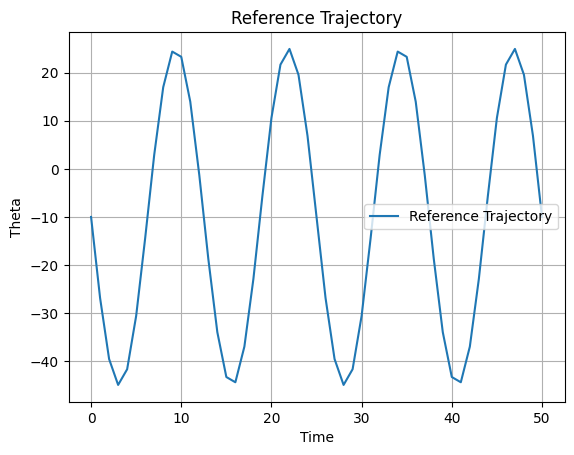

In [64]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(35)      
f_hz = 0.08   
offset_deg = np.deg2rad(-10.0)  
phase_deg = 0.0  
time = 50.0          
dt = 1    
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [11]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=1,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.559710,  lambda_cl=+0.417960

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=7.04°  max|θ̂-R|=1.89°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -7.04 |        -7.04 |       -7.01 |       -2.90 |       -4.79 |         +1.89
lam_min(C^T Q C)=1.39e+00  rho=7.18e-01
L=-1.550419,  lambda_cl=+0.401918

[Rollout] k=1  t=1.000s  ψ_k=-7.01°  max|Δψ|=9.28°  max|θ̂-R|=2.41°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -9.28 |        -9.28 |      -16.29 |       -6.49 |       -8.90 |         +2.41
lam_min(C^T Q C)=1.49e+00  rho=6.72e-01
L=-1.548886,  lambda_cl=+0.399525

[Rollout] k=2  t=2.000s  ψ_k=-16.29°  max|Δψ|=7.82°  max|θ̂-R|=2.02°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_

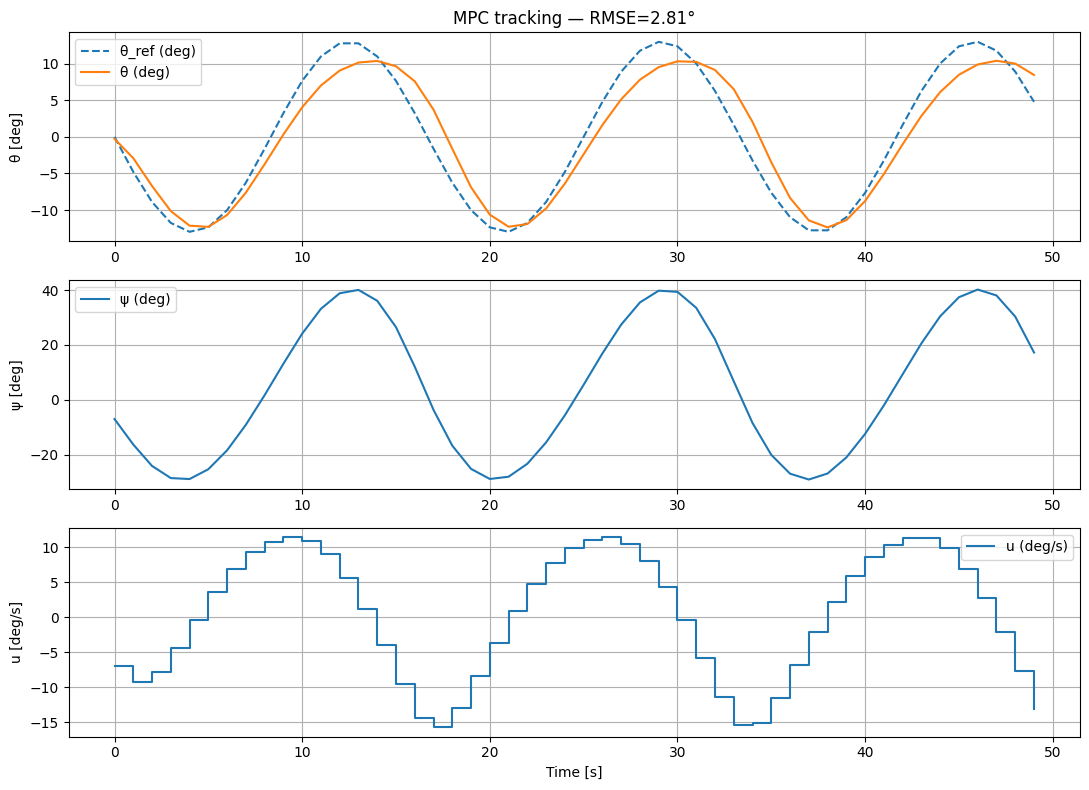

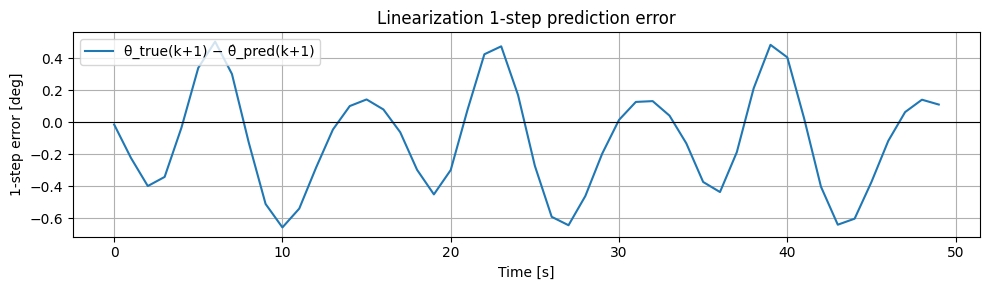

In [12]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [13]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=4,
    w_th=10.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-1.805541,  lambda_cl=+0.326223

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=31.58°  max|θ̂-R|=0.98°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -11.18 |       -11.18 |      -11.15 |       -4.44 |       -4.79 |         +0.34
 2 |        -9.91 |       -21.09 |      -21.06 |       -8.14 |       -8.90 |         +0.76
 3 |        -7.08 |       -28.16 |      -28.14 |      -10.78 |      -11.76 |         +0.98
 4 |        -3.42 |       -31.58 |      -31.55 |      -12.06 |      -12.97 |         +0.92
lam_min(C^T Q C)=3.94e-01  rho=2.54e+00
L=-1.767571,  lambda_cl=+0.312587

[Rollout] k=1  t=1.000s  ψ_k=-11.15°  max|Δψ|=19.86°  max|θ̂-R|=0.89°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |        -9.41 |        

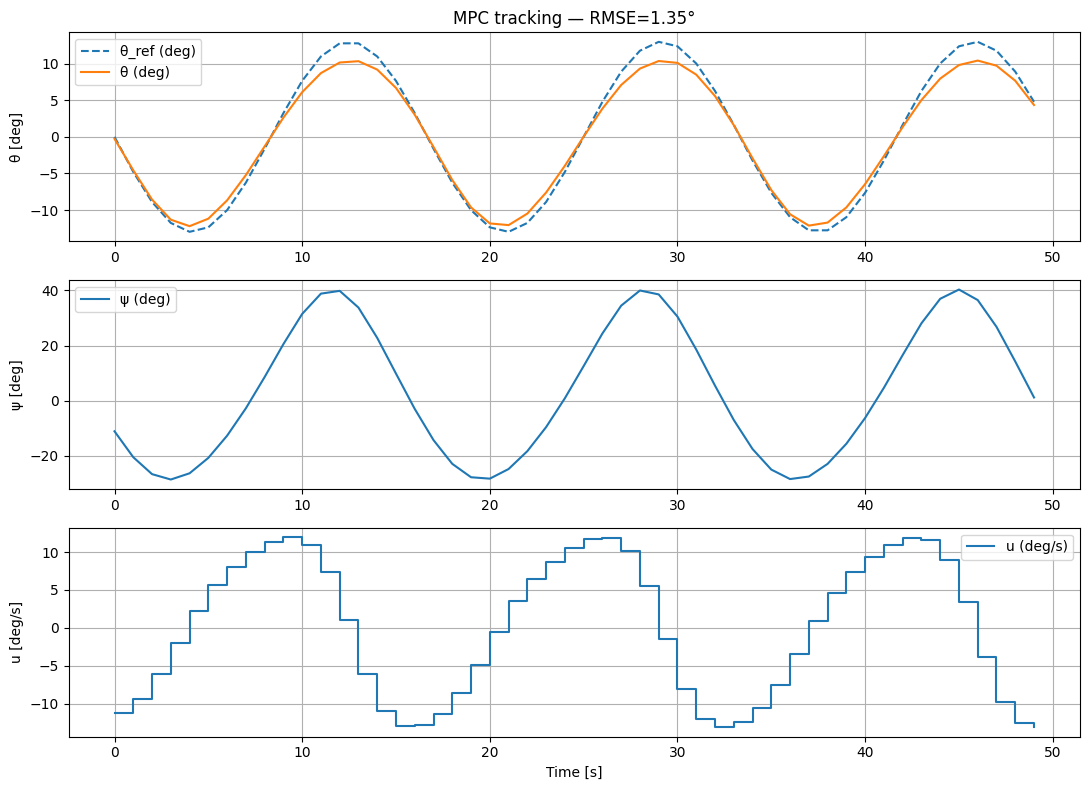

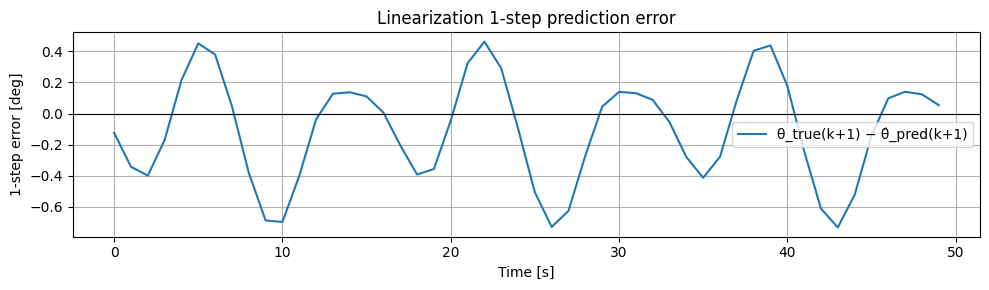

In [14]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [15]:

out = simple_mpc(
    ref, time, dt, p_vec,
    Np=4,
    w_th=100.0, w_u=1, 
    psi0_rad=np.deg2rad(0.028), J_min=1e-5, s_steps=50,
)


/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/3106375270.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L = float(-(E[0, :] @ M))                          # shape: (1 x n) -> scalar for n=1
/var/folders/wh/pxgdh3fs19jfz38nmhhmvsd40000gn/T/ipykernel_19258/1411852970.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_apply = float(u0)


L=-2.510797,  lambda_cl=+0.063041

[Rollout] k=0  t=0.000s  ψ_k=+0.03°  max|Δψ|=33.80°  max|θ̂-R|=0.11°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -12.01 |       -12.01 |      -11.98 |       -4.76 |       -4.79 |         +0.03
 2 |       -10.87 |       -22.88 |      -22.85 |       -8.81 |       -8.90 |         +0.09
 3 |        -7.60 |       -30.48 |      -30.45 |      -11.65 |      -11.76 |         +0.11
 4 |        -3.32 |       -33.80 |      -33.77 |      -12.89 |      -12.97 |         +0.09
lam_min(C^T Q C)=3.94e+00  rho=2.54e-01
L=-2.419539,  lambda_cl=+0.058542

[Rollout] k=1  t=1.000s  ψ_k=-11.98°  max|Δψ|=20.44°  max|θ̂-R|=0.11°
 i |   u_i [deg/s] |   Δψ_i [deg] |  ψ̂_i [deg] |  θ̂_i [deg] |   R_i [deg] | θ̂_i−R_i [deg]
--------------------------------------------------------------------------------------
 1 |       -10.07 |       -

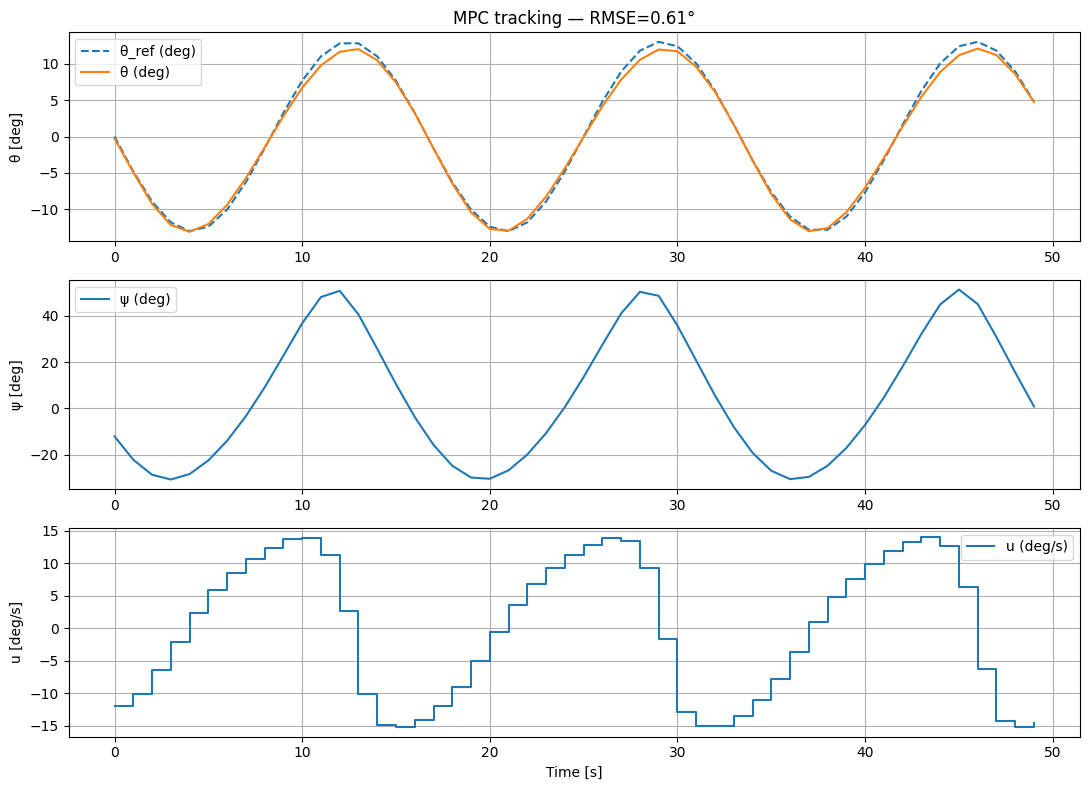

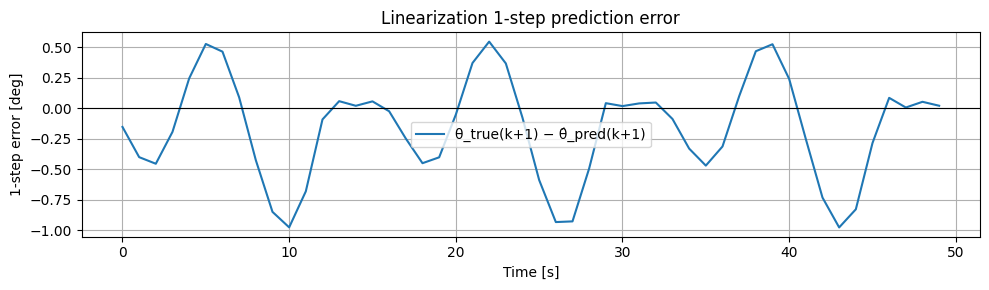

In [16]:

t      = out["t"]
theta  = out["theta_deg"]
thetaR = out["theta_ref_deg"]
psi    = out["psi_deg"]
u      = out["u_deg_s"]
e1     = out["e1_deg"]

rmse = float(np.sqrt(np.mean((theta - thetaR)**2))) if len(theta) else float("nan")

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t, thetaR, "--", label="θ_ref (deg)")
ax1.plot(t, theta,  "-",  label="θ (deg)")
ax1.set_ylabel("θ [deg]")
ax1.set_title(f"MPC tracking — RMSE={rmse:.2f}°")
ax1.grid(True); ax1.legend(loc="best")


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(t, psi, label="ψ (deg)")
ax2.set_ylabel("ψ [deg]")
ax2.grid(True); ax2.legend(loc="best")


ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.step(t, u, where="post", label="u (deg/s)")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("u [deg/s]")
ax3.grid(True); ax3.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, e1, label="θ_true(k+1) − θ̂_pred(k+1)")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Time [s]"); plt.ylabel("1-step error [deg]")
plt.title("Linearization 1-step prediction error")
plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
plt.show()

def plot_horizon_snapshot_from_out(out, k):
    """Uses saved predictions in `out` to show θ̂ vs R, ψ̂, and u over the next Np steps."""
    Np = out["Np"]; dt = out["dt"]
    t0 = out["t"][k]
    tau = t0 + (np.arange(1, Np+1))*dt
    theta_pred = out["pred_theta_deg"][k]
    ref_pred   = out["pred_ref_deg"][k]
    psi_pred   = out["pred_psi_deg"][k]
    u_pred     = out["pred_u_deg_s"][k]

    plt.figure(figsize=(10,4))
    plt.plot(tau, theta_pred, label="θ̂ pred [deg]")
    plt.plot(tau, ref_pred,  "--", label="R [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("θ [deg]")
    plt.title(f"Horizon prediction at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.step(tau, u_pred, where="post", label="u [deg/s]")
    plt.plot(tau, psi_pred, label="ψ̂ [deg]")
    plt.xlabel("Time [s]"); plt.ylabel("u / ψ̂")
    plt.title(f"Horizon inputs & ψ̂ at k={k}, t={t0:.2f}s")
    plt.grid(True); plt.legend(loc="best"); plt.tight_layout()
    plt.show()


In [ ]:
def validate_linearization_at(psi_k_deg, *, p_vec, dmax_deg=20.0, n_pts=41, s_steps=200):

    psi_k = np.deg2rad(psi_k_deg)

    def measure_theta(psi_rad):
        th, _, _, _ = simulate_beam(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(th)

    def jacobian_at(psi_rad):
        _, Jpsi, _ = jacobian_tip_from_sim2(
            p_vec, np.rad2deg(psi_rad),
            L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M,
            m_line_of_s=m_line_of_s, s_steps=s_steps
        )
        return float(Jpsi)

    theta0 = measure_theta(psi_k)
    J0     = jacobian_at(psi_k)

    dpsi_list = np.linspace(-np.deg2rad(dmax_deg), np.deg2rad(dmax_deg), n_pts)
    theta_true = np.array([measure_theta(psi_k + d) for d in dpsi_list])
    theta_lin  = theta0 + J0 * dpsi_list

    err = theta_true - theta_lin
    rmse = float(np.sqrt(np.mean(err**2)))
    max_abs = float(np.max(np.abs(err)))

    print(f"ψk={psi_k_deg:.2f} deg:  J0={J0:.4g} rad/rad,  RMSE={np.degrees(rmse):.4f} deg,  max|err|={np.degrees(max_abs):.4f} deg")

    plt.figure()
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_true), label="θ true")
    plt.plot(np.degrees(psi_k + dpsi_list), np.degrees(theta_lin),  "--", label="θ linear")
    plt.xlabel("ψ [deg]"); plt.ylabel("θ [deg]"); plt.title(f"Linearization @ p={np.array(p_vec)}")
    plt.grid(True); plt.legend()

    plt.figure()
    plt.plot(np.degrees(dpsi_list), np.degrees(err))
    plt.xlabel("Δψ [deg]"); plt.ylabel("θ_true - θ_lin [deg]")
    plt.title("Linearization error vs Δψ")
    plt.grid(True)

    return dict(
        p_vec=np.array(p_vec, float),
        psi_k_deg=float(psi_k_deg),
        J0=float(J0),
        theta0=float(theta0),
        rmse=rmse,
        max_abs=max_abs,
    )


ψk=30.55 deg:  J0=0.2079 rad/rad,  RMSE=0.0374 deg,  max|err|=0.1010 deg


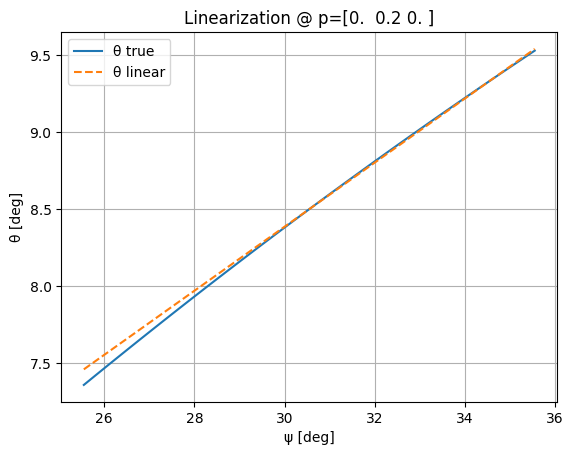

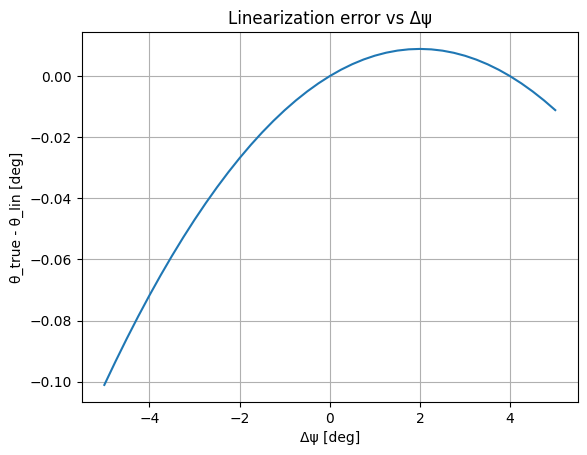

In [ ]:
k = -1
# reconstruct ψ before applying u at step k:
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=5.0, n_pts=41)


ψk=31.83 deg:  J0=0.2748 rad/rad,  RMSE=1.1330 deg,  max|err|=2.9391 deg


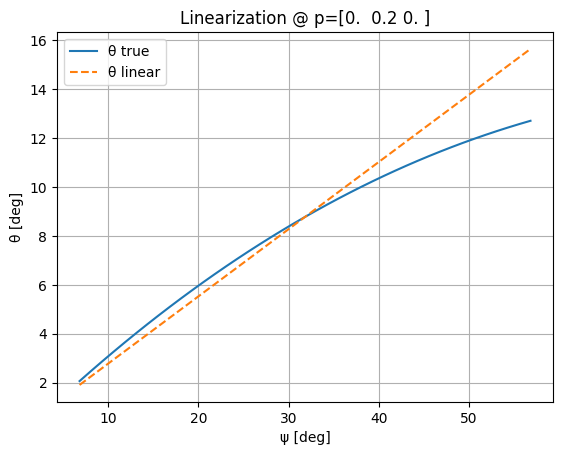

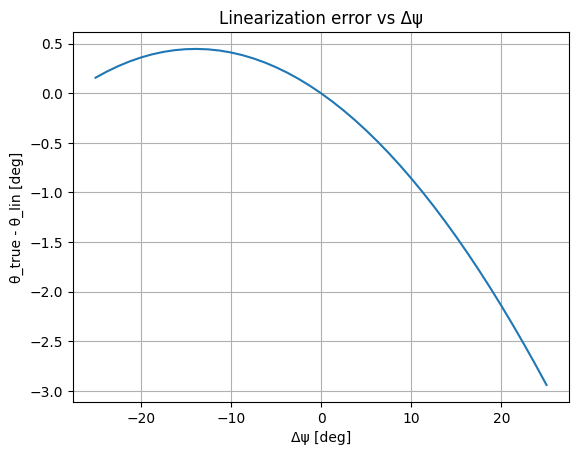

In [ ]:
k = -1
psi_before_deg = out["psi_deg"][k] - out["u_deg_s"][k]*dt
res = validate_linearization_at(psi_before_deg, p_vec=p_vec, dmax_deg=25.0, n_pts=41)


Now a trust region is developed to ensure the change in EPM rotation does not cause linearisation erros. To do this we will take the gradient of the jacobian which will approximate the curvature of the sensitivity. This then defines the linearisation limits by defining the maximum linearisation error.

In [4]:

def jacobian_at(psi_rad, sim):
    _, Jpsi, _ = jacobian_tip_from_sim2(
        p_vec, np.rad2deg(psi_rad),sim=sim
    )
    return float(Jpsi)

def trust_region(jacobian_at, h,psi_rad, error):
    Jp = jacobian_at(psi+h)
    Jm = jacobian_at(psi-h)
    Jprime = (Jp-Jm)/(2*h)
    all_error = np.deg2rad(error)
    L = max(Jprime, 1e-5)
    dpsi_max = np.sqrt((2*all_error)/(L))
    return dpsi_max

We now apply the constraints and solve the minimisation problem. To do this we import a library which is a QP solver.

In [6]:
def mpc_stack(A, B, Q, R, Qf, N):
    n, m = A.shape[0], B.shape[1]
    M, C = seq_mat(A, B, N)
    Qtil = diag_bl(Q, N-1)
    Qtil = np.block([
        [Qtil, np.zeros(((N-1)*n, n))],
        [np.zeros((n, (N-1)*n)), Qf]
    ])
    Rtil = diag_bl(R, N)
    return M, C, Qtil, Rtil

def mpc_cost(M, C, Qtil, Rtil, xk, xref_seq):
    H = 2.0 * (C.T @ Qtil @ C + Rtil)
    F = 2.0 *  C.T @ Qtil @ (M @ xk - xref_seq)
    H = 0.5 * (H + H.T)
    return H, F


In [7]:
def mpc_step_unconstrained(A, B, Q, R, Qf, N, xk, xref_seq):
    M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
    H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)
    U = -np.linalg.solve(H, F)        
    X_pred = M @ xk + C @ U
    return U, X_pred, (H, F, M, C, Qtil)


In [773]:
import numpy as np
import scipy.sparse as sp
import osqp

def solve_qp_osqp(H, F, A, l, u, U_warm=None):
    P = sp.csc_matrix(0.5*(H + H.T))
    q = F.astype(float)
    A = sp.csc_matrix(A)
    prob = osqp.OSQP()
    prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=False, eps_abs=1e-6, eps_rel=1e-6)
    if U_warm is not None:
        prob.warm_start(x=U_warm)
    res = prob.solve()
    status = res.info.status 
    if status not in ("solved", "solved inaccurate"):
        return None, None, status
    return res.x, res.y, status             


In [ ]:
def mpc_step_trust_region(A, B, Q, R, Qf, N, xk, xref_seq, dt, dpsi_max):
    M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
    H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)

    S = np.tril(np.ones((N, N), float)) * dt

    l = -np.ones(N) * dpsi_max
    u = +np.ones(N) * dpsi_max
    U, y = solve_qp_osqp(H, F, S, l, u)

    X_pred = M @ xk + C @ U
    
    return U, X_pred, (H, F, M, C, Qtil, S, (l, u), y)


In [885]:
def jacobian_at(psi_rad, sim_for_curvature):
    _, Jpsi, _ = jacobian_tip_from_sim2(
        p_vec, psi_rad, L=LENGTH, m_line_of_s=m_line_of_s,
        s_steps=sim_for_curvature.get("s_steps", 10), sim=sim_for_curvature
    )
    return float(Jpsi)


def trust_radius(jac_fn,
                 psi_rad,
                 h_rad=np.deg2rad(0.5),
                 eps_theta_rad=np.deg2rad(1.0),
                 Jmin=1e-6,
                 Lmin=1e-6,
                 dpsi_cap=np.deg2rad(5.0)):
    # J and its numerical derivative
    J0 = float(jac_fn(psi_rad))
    Jp = float(jac_fn(psi_rad + h_rad))
    Jm = float(jac_fn(psi_rad - h_rad))
    Jprime = (Jp - Jm) / (2.0*h_rad)

    # linear & quadratic (curvature) bounds
    dpsi_lin  = eps_theta_rad / max(abs(J0),    Jmin)
    dpsi_quad = (2.0*eps_theta_rad / max(abs(Jprime), Lmin))**0.5

    # final trust radius: conservative + capped
    dpsi = min(dpsi_lin, dpsi_quad, dpsi_cap)
    return dpsi, {"J0": J0, "Jprime": Jprime, "dpsi_lin": dpsi_lin, "dpsi_quad": dpsi_quad}



In [250]:
p_vec = np.array([0,0.18,0])
_, J0_tr_test, _ = jacobian_tip_from_sim2(
    p_vec, np.pi/3, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
    MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
    GRAD_SCALE=1.0, s_steps=10, sim=None
)
J0_tr_test2 = J_fn(np.pi/3)
print(J0_tr_test, J0_tr_test2)


0.12533795436637812 0.09321822896186328


In [362]:
def mpc_compare_logged(ref, T, dt, p_vec, *,
                       Np=15, w_th=1.0, w_u=1e-3,
                       psi0_rad=0.0, J_min=1e-5, s_steps=10,
                       eps_theta_deg=10.0, h_deg_for_radius=0.5,sigma_theta_meas_deg=0.2):


    S = np.tril(np.ones((Np, Np), float)) * dt

    log = dict(
        t=[], theta_ref_deg=[],

        psi_free_deg=[], u_free_deg_s=[], theta0_free_deg=[], theta_pred_free_k1_deg=[],
        psi_tr_deg=[],   u_tr_deg_s=[],   theta0_tr_deg=[],   theta_pred_tr_k1_deg=[],

        dpsi_max_deg=[], viol_free_deg=[], viol_tr_deg=[], du0_deg_s=[],
        active_upper_cnt=[], active_lower_cnt=[],

        theta_true_next_free_deg=[], theta_true_next_tr_deg=[],
    )
    rng = np.random.default_rng(2)
    
    sigma_theta_meas = np.deg2rad(sigma_theta_meas_deg)

    psi_free = float(psi0_rad)
    psi_tr   = float(psi0_rad)

    N = int(round(T/dt))
    for k in range(N):
        t = k*dt

        psi_k_free = psi_free
        theta0_free, _, sol_true_fr, info_true_fr = simulate_beam(
            p_vec, np.rad2deg(psi_k_free), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        sol_noisy_fr = types.SimpleNamespace()
        sol_noisy_fr.t = sol_true_fr.t.copy()
        sol_noisy_fr.y = sol_true_fr.y.copy()
        sol_noisy_fr.y[0, :] += rng.normal(0.0, sigma_theta_meas, size=sol_noisy_fr.y[0,:].shape)

        sim_noisy_free = {"theta_tip": float(sol_noisy_fr.y[0,-1]), "sol_ivp": sol_noisy_fr, "info": info_true_fr}


        _, J0_free, _ = jacobian_tip_from_sim2(
            p_vec, psi_k_free, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
            GRAD_SCALE=1.0, s_steps=s_steps, sim=sim_noisy_free
        )

 
        A_th = np.array([[1.0]])
        B_th_free = np.array([[max(abs(J0_free), J_min) * np.sign(J0_free) * dt]])
        Q_th = np.array([[w_th]]); R_u = np.array([[w_u]]); Qf_th = Q_th
        theta_meas_free = float(sol_noisy_fr.y[0, -1])
        xk_free = np.array([theta_meas_free])
        

        # xk_free = np.array([theta0_free])
        xref = np.array([ref(t + (i+1)*dt)[0] for i in range(Np)], float)

        U_free, X_free, _ = mpc_step_unconstrained(A_th, B_th_free, Q_th, R_u, Qf_th, Np, xk_free, xref)
        u0_free = float(U_free[0])
        ANGLE_LIM = 0.5*np.pi  # = pi/2
        u_min = (-ANGLE_LIM - psi_free) / dt
        u_max = ( +ANGLE_LIM - psi_free) / dt
        u0_free = np.clip(u0_free, u_min, u_max)
        psi_free_next = psi_free + u0_free*dt


        psi_k_tr = psi_tr
        theta0_tr, _, sol_true_tr, info_true_tr = simulate_beam(
            p_vec, np.rad2deg(psi_k_tr), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        sol_noisy_tr = types.SimpleNamespace()
        sol_noisy_tr.t = sol_true_tr.t.copy()
        sol_noisy_tr.y = sol_true_tr.y.copy()
        sol_noisy_tr.y[0, :] += rng.normal(0.0, sigma_theta_meas, size=sol_noisy_tr.y[0,:].shape)

        sim_noisy_tr = {"theta_tip": float(sol_noisy_tr.y[0,-1]), "sol_ivp": sol_noisy_tr, "info": info_true_tr}


        _, J0_tr, _ = jacobian_tip_from_sim2(
            p_vec, psi_k_tr, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
            MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
            GRAD_SCALE=1.0, s_steps=s_steps, sim=sim_noisy_tr
        )

        B_th_tr = np.array([[max(abs(J0_tr), J_min) * np.sign(J0_tr) * dt]])
        # xk_tr = np.array([theta0_tr])
        theta_meas_tr   = float(sol_noisy_tr.y[0, -1])
        xk_tr   = np.array([theta_meas_tr])
        eps_theta_rad = np.deg2rad(eps_theta_deg)
        dpsi_max = trust_radius(lambda psiq: jacobian_at(psiq, sim_noisy_tr),
                                psi_k_tr, h_rad=np.deg2rad(h_deg_for_radius),
                                eps_theta_rad=eps_theta_rad)

        U_tr, X_tr, tr_pack = mpc_step_trust_region(A_th, B_th_tr, Q_th, R_u, Qf_th,
                                                    Np, xk_tr, xref, dt, dpsi_max)
        u0_tr = float(U_tr[0])
        psi_tr_next = psi_tr + u0_tr*dt


        viol_free = float(np.max(np.abs(S @ U_free)))
        viol_tr   = float(np.max(np.abs(S @ U_tr)))

     
        y_dual = tr_pack[-1]
        act_upper = int(np.sum(y_dual > +1e-6))
        act_lower = int(np.sum(y_dual < -1e-6))


        theta_true_next_free, *_ = simulate_beam(
            p_vec, np.rad2deg(psi_free_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )
        theta_true_next_tr, *_ = simulate_beam(
            p_vec, np.rad2deg(psi_tr_next), L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val
        )

        log["t"].append(t)
        log["theta_ref_deg"].append(np.degrees(xref[0]))

        log["psi_free_deg"].append(np.degrees(psi_free))
        log["u_free_deg_s"].append(np.degrees(u0_free))
        log["theta0_free_deg"].append(np.degrees(theta0_free))
        log["theta_pred_free_k1_deg"].append(np.degrees(X_free[0]))

        log["psi_tr_deg"].append(np.degrees(psi_tr))
        log["u_tr_deg_s"].append(np.degrees(u0_tr))
        log["theta0_tr_deg"].append(np.degrees(theta0_tr))
        log["theta_pred_tr_k1_deg"].append(np.degrees(X_tr[0]))

        log["dpsi_max_deg"].append(np.degrees(dpsi_max))
        log["viol_free_deg"].append(np.degrees(viol_free))
        log["viol_tr_deg"].append(np.degrees(viol_tr))
        log["du0_deg_s"].append(np.degrees(u0_tr - u0_free))
        log["active_upper_cnt"].append(act_upper)
        log["active_lower_cnt"].append(act_lower)

        log["theta_true_next_free_deg"].append(np.degrees(theta_true_next_free))
        log["theta_true_next_tr_deg"].append(np.degrees(theta_true_next_tr))

        psi_free = psi_free_next
        psi_tr   = psi_tr_next


        print(f"[k={k}] dψ_max={np.degrees(dpsi_max):.2f}° | "
              f"‖S U_free‖∞={np.degrees(viol_free):.2f}° | "
              f"‖S U_tr‖∞={np.degrees(viol_tr):.2f}° | "
              f"Δu0={np.degrees(u0_tr-u0_free):+.2f} °/s | "
              f"act(↑,↓)=({act_upper},{act_lower})")


    for k in list(log.keys()):
        if k not in ("Np","dt"):
            log[k] = np.asarray(log[k], float)
    log["Np"] = Np; log["dt"] = dt
    return log


In [65]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=400, eps_theta_deg=0.5)



[k=0] dψ_max=52.51° | ‖S U_free‖∞=56.54° | ‖S U_tr‖∞=52.51° | Δu0=+0.35 °/s | act(↑,↓)=(0,1)
[k=1] dψ_max=7.17° | ‖S U_free‖∞=33.34° | ‖S U_tr‖∞=7.17° | Δu0=-26.17 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=6.89° | ‖S U_free‖∞=62.47° | ‖S U_tr‖∞=6.89° | Δu0=+66.48 °/s | act(↑,↓)=(2,0)
[k=3] dψ_max=7.20° | ‖S U_free‖∞=205.32° | ‖S U_tr‖∞=7.20° | Δu0=+88.21 °/s | act(↑,↓)=(2,0)
[k=4] dψ_max=6.90° | ‖S U_free‖∞=38.23° | ‖S U_tr‖∞=6.90° | Δu0=-31.33 °/s | act(↑,↓)=(3,0)
[k=5] dψ_max=8.31° | ‖S U_free‖∞=106.29° | ‖S U_tr‖∞=8.31° | Δu0=+58.55 °/s | act(↑,↓)=(3,0)
[k=6] dψ_max=14.80° | ‖S U_free‖∞=60.77° | ‖S U_tr‖∞=14.80° | Δu0=+29.76 °/s | act(↑,↓)=(3,0)
[k=7] dψ_max=21.90° | ‖S U_free‖∞=56.05° | ‖S U_tr‖∞=21.90° | Δu0=+58.80 °/s | act(↑,↓)=(3,0)
[k=8] dψ_max=14.63° | ‖S U_free‖∞=44.74° | ‖S U_tr‖∞=14.63° | Δu0=+59.36 °/s | act(↑,↓)=(2,0)
[k=9] dψ_max=14.15° | ‖S U_free‖∞=136.96° | ‖S U_tr‖∞=14.15° | Δu0=-9.44 °/s | act(↑,↓)=(1,1)
[k=10] dψ_max=14.23° | ‖S U_free‖∞=197.74° | ‖S U_tr‖∞=14.23° | Δu0=-

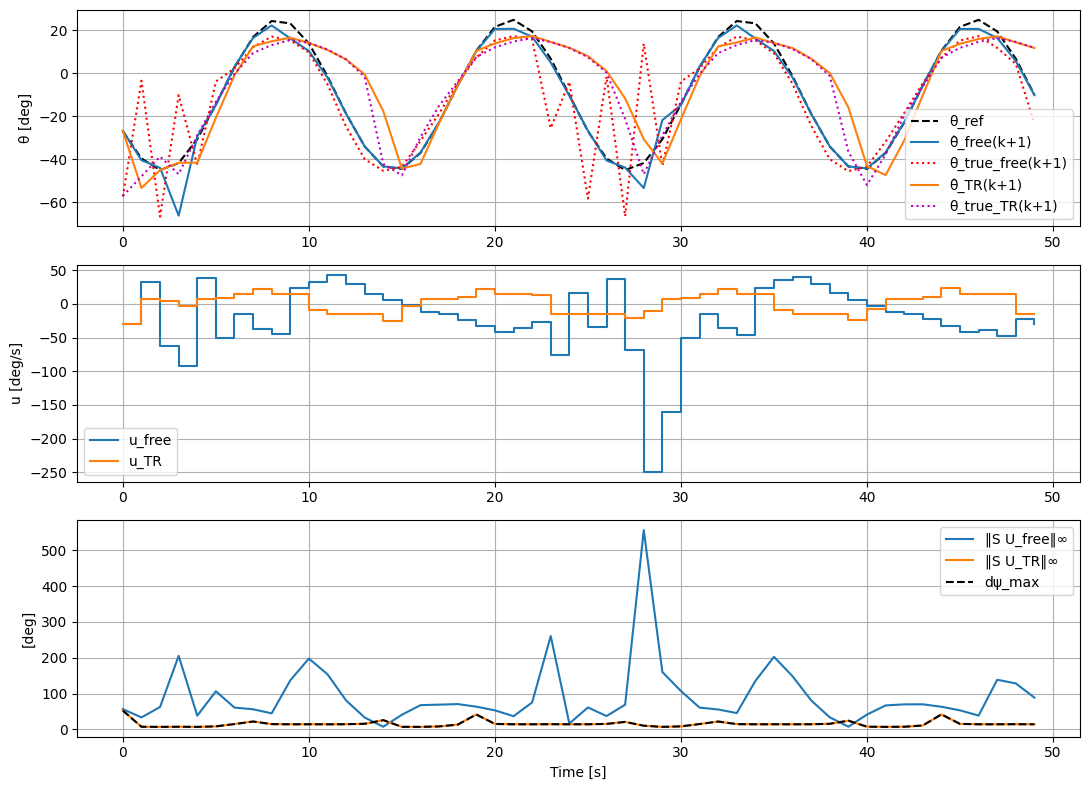

In [68]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

In [69]:
log = mpc_compare_logged(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=3, w_th=100.0, w_u=1.0,
                         psi0_rad=np.deg2rad(-10), J_min=1e-5,
                         s_steps=400, eps_theta_deg=5.0)



[k=0] dψ_max=166.04° | ‖S U_free‖∞=56.54° | ‖S U_tr‖∞=56.18° | Δu0=+0.35 °/s | act(↑,↓)=(0,0)
[k=1] dψ_max=22.66° | ‖S U_free‖∞=33.34° | ‖S U_tr‖∞=22.66° | Δu0=-10.67 °/s | act(↑,↓)=(3,0)
[k=2] dψ_max=45.87° | ‖S U_free‖∞=62.47° | ‖S U_tr‖∞=37.89° | Δu0=+24.57 °/s | act(↑,↓)=(0,0)
[k=3] dψ_max=25.81° | ‖S U_free‖∞=205.32° | ‖S U_tr‖∞=25.81° | Δu0=+117.51 °/s | act(↑,↓)=(3,0)
[k=4] dψ_max=22.45° | ‖S U_free‖∞=38.23° | ‖S U_tr‖∞=22.45° | Δu0=-27.12 °/s | act(↑,↓)=(2,0)
[k=5] dψ_max=42.37° | ‖S U_free‖∞=106.29° | ‖S U_tr‖∞=37.47° | Δu0=+50.44 °/s | act(↑,↓)=(0,0)
[k=6] dψ_max=43.02° | ‖S U_free‖∞=60.77° | ‖S U_tr‖∞=43.02° | Δu0=+35.59 °/s | act(↑,↓)=(1,0)
[k=7] dψ_max=57.20° | ‖S U_free‖∞=56.05° | ‖S U_tr‖∞=40.68° | Δu0=+63.74 °/s | act(↑,↓)=(0,0)
[k=8] dψ_max=44.97° | ‖S U_free‖∞=44.74° | ‖S U_tr‖∞=37.75° | Δu0=+82.49 °/s | act(↑,↓)=(0,0)
[k=9] dψ_max=46.36° | ‖S U_free‖∞=136.96° | ‖S U_tr‖∞=46.36° | Δu0=-19.28 °/s | act(↑,↓)=(0,1)
[k=10] dψ_max=46.75° | ‖S U_free‖∞=197.74° | ‖S U_tr‖∞=4

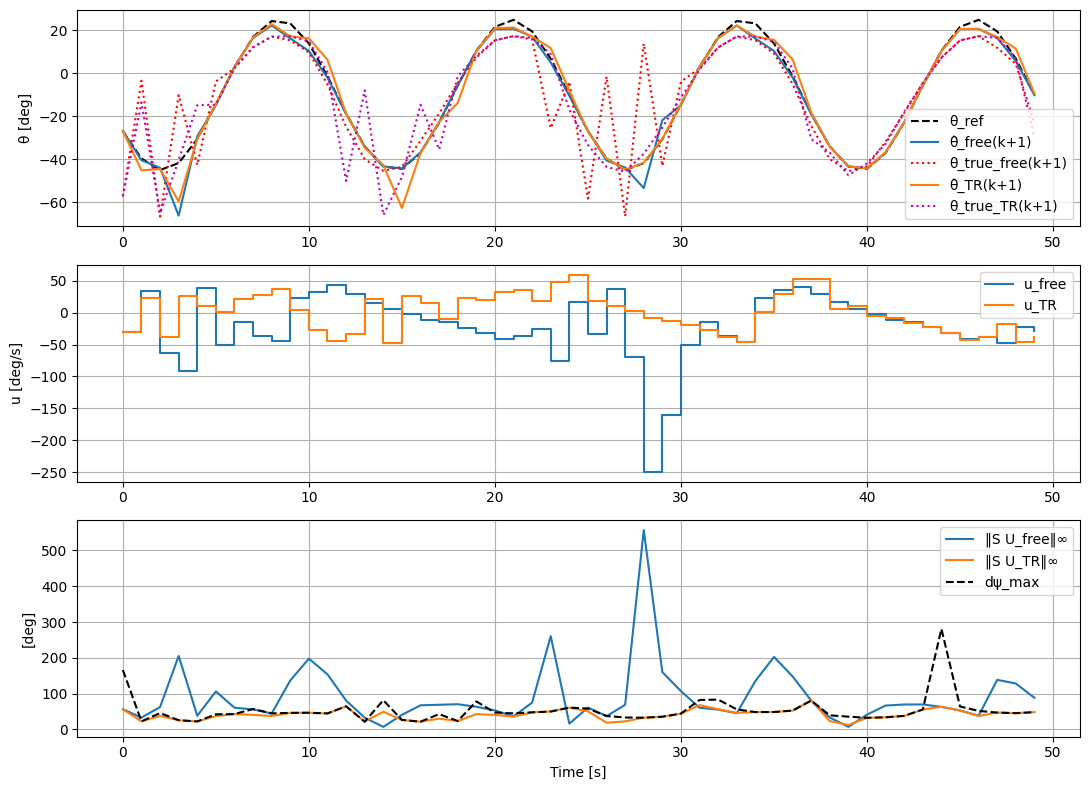

In [72]:
t = log["t"]

plt.figure(figsize=(11,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,      log["theta_ref_deg"], "k--", label="θ_ref")
ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label="θ_true_free(k+1)")
ax1.plot(t, log["theta_pred_tr_k1_deg"],   label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"], "m:", label="θ_true_TR(k+1)")
ax1.set_ylabel("θ [deg]"); ax1.legend(); ax1.grid(True)


ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_ylabel("u [deg/s]"); ax2.legend(); ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]"); ax3.legend(); ax3.grid(True)
plt.tight_layout(); plt.show()

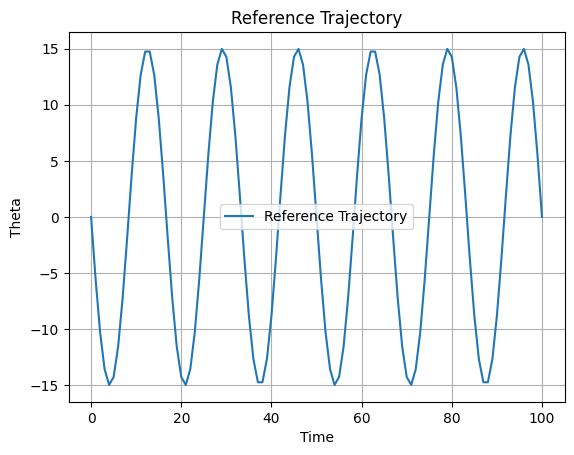

In [112]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(15)      
f_hz = 0.06
offset_deg = np.deg2rad(0.0)  
phase_deg = 0.0  
time = 100.0          
dt = 1    
Np = 3   
ref = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(test)[0] for test in t])
theta_dot = np.array([ref(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

Instead of simulating the beam and caluclating the jacobian at each point this is now approximated through a linear spline and look up table which increases the speed.

In [383]:
def mpc_compare_logged2(ref, T, dt, p_vec, *,
                       Np=15, w_th=1.0, w_u=1e-3,
                       psi0_rad=0.0, J_min=1e-5, s_steps=10,
                       eps_theta_deg=10.0, h_deg_for_radius=0.5, sigma_theta_meas_deg=0.2):

    S = np.tril(np.ones((Np, Np), float)) * dt
    rng = np.random.default_rng(2)
    sigma_theta_meas = np.deg2rad(sigma_theta_meas_deg)

    log = dict(
        t=[], theta_ref_deg=[],

        psi_free_deg=[], u_free_deg_s=[], theta0_free_deg=[], theta_pred_free_k1_deg=[],
        psi_tr_deg=[],   u_tr_deg_s=[],   theta0_tr_deg=[],   theta_pred_tr_k1_deg=[],

        dpsi_max_deg=[], viol_free_deg=[], viol_tr_deg=[], du0_deg_s=[],
        active_upper_cnt=[], active_lower_cnt=[],

        theta_true_next_free_deg=[], theta_true_next_tr_deg=[],
        e_traj_free_deg=[], e_traj_tr_deg=[],
        se_traj_free_deg2=[], se_traj_tr_deg2=[],
    )

    psi_free = float(psi0_rad)
    psi_tr   = float(psi0_rad)

    N = int(round(T/dt))
    for k in range(N):
        t = k*dt

        psi_k_free = psi_free
        theta0_free   = float(theta_fn(np.rad2deg(psi_k_free)))
        theta0_free_n = float(theta0_free + rng.normal(0.0, sigma_theta_meas))
        J0_free       = float(J_fn(psi_k_free))
        # theta_tip, k_star, sol_ivp, info = simulate_beam(
        #     p_vec=p_vec,
        #     psi_deg=np.rad2deg(psi_k_free),
        #     L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        #     MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        #     s_steps=200
        # )
        # _, J_tip, _ = jacobian_tip_from_sim2(
        #     p_vec, psi_k_free, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        #     MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        #     GRAD_SCALE=1.0, s_steps=400
        # )

        # print(f"ψ={np.degrees(psi_k_free):.3f}° | θ_fit={np.degrees(theta0_free):.3f}° "
        #     f"| θ_true={np.degrees(theta_tip):.3f}° | J_fit={J0_free:.4f} | J_true={J_tip:.4f}")


        A_th = np.array([[1.0]])
        B_th_free = np.array([[max(abs(J0_free), J_min) * np.sign(J0_free) * dt]])        
        Q_th = np.array([[w_th]]); R_u = np.array([[w_u]]); Qf_th = Q_th

        xk_free = np.array([theta0_free_n])
        xref = np.array([ref(t + (i+1)*dt)[0] for i in range(Np)], float)

        U_free, X_free, _ = mpc_step_unconstrained(A_th, B_th_free, Q_th, R_u, Qf_th, Np, xk_free, xref)
        u0_free = float(np.ravel(U_free)[0])
        ANGLE_LIM = 0.5*np.pi  # = pi/2
        u_min = (-ANGLE_LIM - psi_free) / dt
        u_max = ( +ANGLE_LIM - psi_free) / dt
        u0_free = np.clip(u0_free, u_min, u_max)
        psi_free_next = psi_free + u0_free*dt


        psi_k_tr = psi_tr
        theta0_tr   = float(theta_fn(np.degrees(psi_k_tr)))
        theta0_tr_n = float(theta0_tr + rng.normal(0.0, sigma_theta_meas))
        J0_tr       = float(J_fn(psi_k_tr))
        B_th_tr = np.array([[max(abs(J0_tr), J_min) * np.sign(J0_tr) * dt]])        
        xk_tr = np.array([theta0_tr_n])

        eps_theta_rad = np.deg2rad(eps_theta_deg)
        dpsi_max = trust_radius(lambda psiq: float(J_fn(psiq)),
                                psi_k_tr, h_rad=np.deg2rad(h_deg_for_radius),
                                eps_theta_rad=eps_theta_rad)

        U_tr, X_tr, tr_pack = mpc_step_trust_region(A_th, B_th_tr, Q_th, R_u, Qf_th,
                                                    Np, xk_tr, xref, dt, dpsi_max)
        u0_tr = float(np.ravel(U_tr)[0])
        psi_tr_next = psi_tr + u0_tr*dt

        U_free_vec = np.asarray(U_free, float).reshape(-1)
        U_tr_vec   = np.asarray(U_tr,   float).reshape(-1)
        viol_free  = float(np.max(np.abs(S @ U_free_vec)))
        viol_tr    = float(np.max(np.abs(S @ U_tr_vec)))

        theta_true_next_free = float(theta_fn(np.degrees(psi_free_next)))
        theta_true_next_tr   = float(theta_fn(np.degrees(psi_tr_next)))

        log["t"].append(t)
        log["theta_ref_deg"].append(np.degrees(xref[0]))

        log["psi_free_deg"].append(np.degrees(psi_free))
        log["u_free_deg_s"].append(np.degrees(u0_free))
        log["theta0_free_deg"].append(np.degrees(theta0_free))
        log["theta_pred_free_k1_deg"].append(np.degrees(float(np.ravel(X_free)[0])))

        log["psi_tr_deg"].append(np.degrees(psi_tr))
        log["u_tr_deg_s"].append(np.degrees(u0_tr))
        log["theta0_tr_deg"].append(np.degrees(theta0_tr))
        log["theta_pred_tr_k1_deg"].append(np.degrees(float(np.ravel(X_tr)[0])))

        log["dpsi_max_deg"].append(np.degrees(dpsi_max))
        log["viol_free_deg"].append(np.degrees(viol_free))
        log["viol_tr_deg"].append(np.degrees(viol_tr))
        log["du0_deg_s"].append(np.degrees(u0_tr - u0_free))

        y_dual = tr_pack[-1]
        log["active_upper_cnt"].append(int(np.sum(y_dual > +1e-6)))
        log["active_lower_cnt"].append(int(np.sum(y_dual < -1e-6)))

        log["theta_true_next_free_deg"].append(np.degrees(theta_true_next_free))
        log["theta_true_next_tr_deg"].append(np.degrees(theta_true_next_tr))
        e_free = log["theta_true_next_free_deg"][-1] - log["theta_ref_deg"][-1]
        e_tr   = log["theta_true_next_tr_deg"][-1]   - log["theta_ref_deg"][-1]

        log["e_traj_free_deg"].append(e_free)
        log["e_traj_tr_deg"].append(e_tr)
        log["se_traj_free_deg2"].append(e_free**2)
        log["se_traj_tr_deg2"].append(e_tr**2)
        psi_free = psi_free_next
        psi_tr   = psi_tr_next

    for k in list(log.keys()):
        if k not in ("Np","dt"):
            log[k] = np.asarray(log[k], float)

    log["rmse_traj_free_deg"] = float(np.sqrt(np.mean(log["se_traj_free_deg2"]))) if log["se_traj_free_deg2"].size else np.nan
    log["rmse_traj_tr_deg"]   = float(np.sqrt(np.mean(log["se_traj_tr_deg2"])))   if log["se_traj_tr_deg2"].size   else np.nan

    log["Np"] = Np; log["dt"] = dt
    return log



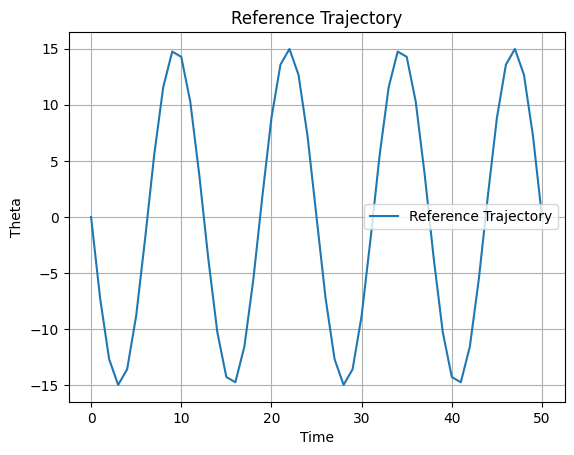

In [1057]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(15)      
f_hz = 0.08
offset_deg = np.deg2rad(0.0)  
phase_deg = 0.0  
time = 50.0          
dt = 1   
Np = 3   
ref_sine = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta_ref = np.array([ref_sine(test)[0] for test in t])
theta_dot = np.array([ref_sine(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta_ref), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

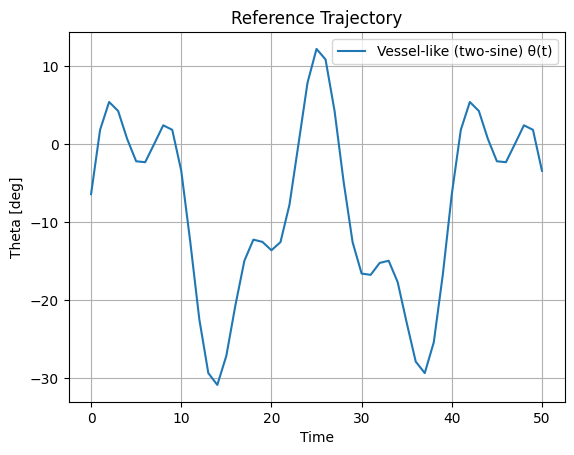

In [1195]:
def make_ref_tortuous(A_rad, f_slow, f_fast, offset_rad=0.0, phase_rad=0.0):
    A1 = A_rad             
    A2 = 0.5 * A_rad           
    phi2 = 0.5                 
    def ref(t):
        th  = (offset_rad
               + A1*np.sin(2*np.pi*f_slow*t + phase_rad)
               + A2*np.sin(2*np.pi*f_fast*t + phi2))
        thd = (2*np.pi) * (A1*f_slow*np.cos(2*np.pi*f_slow*t + phase_rad)
                           + A2*f_fast*np.cos(2*np.pi*f_fast*t + phi2))
        return th, thd
    return ref

p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(15)
f_hz  = 0.05
offset_deg = np.deg2rad(-10.0)
phase_deg  = 0.0
time = 50.0
dt = 1
Np = 3

ref = make_ref_tortuous(A_deg, f_slow=f_hz, f_fast=2.5*f_hz, offset_rad=offset_deg, phase_rad=phase_deg)

t = np.arange(0.0, time+dt, dt)
theta = np.array([ref(tt)[0] for tt in t])
theta_dot = np.array([ref(tt)[1] for tt in t])

plt.figure()
plt.plot(t, np.rad2deg(theta), label="Vessel-like (two-sine) θ(t)")
plt.xlabel("Time")
plt.ylabel("Theta [deg]")
plt.title("Reference Trajectory")
plt.legend()
plt.grid(True)
plt.show()



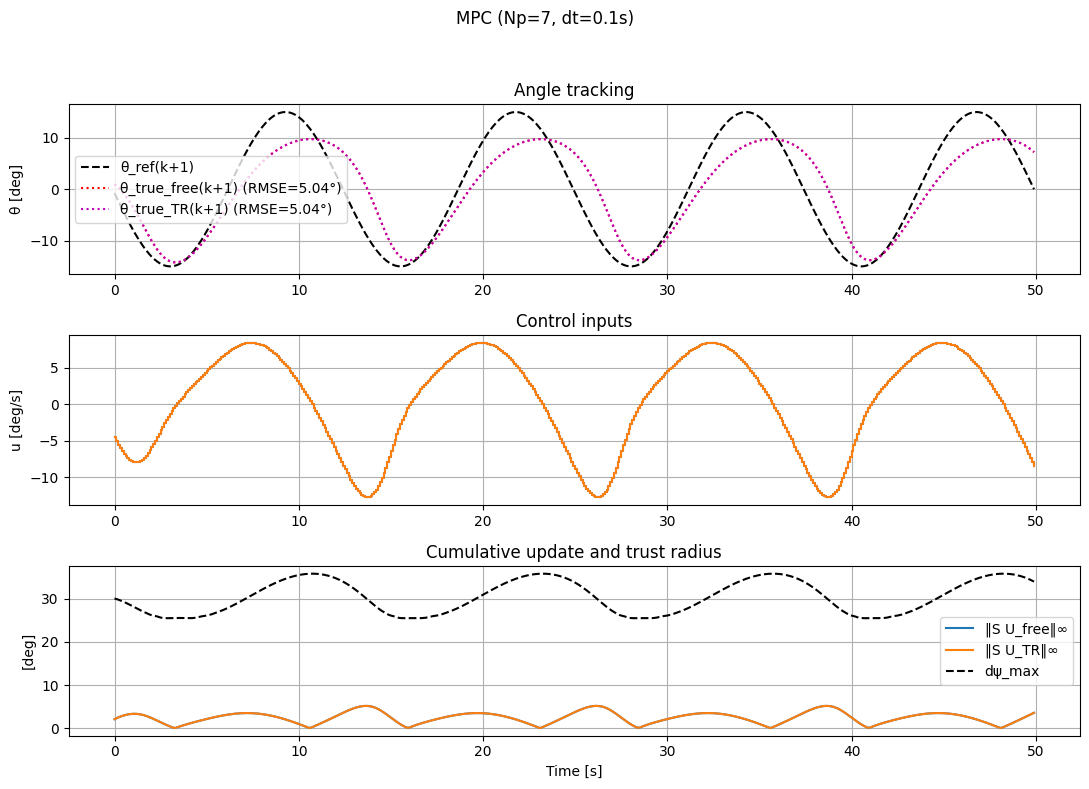

In [730]:
log = mpc_compare_logged2(ref, T=time, dt=dt, p_vec=p_vec,
                         Np=7, w_th=10.0, w_u=3.0,
                         psi0_rad=np.deg2rad(0), J_min=1e-5,
                         s_steps=10, eps_theta_deg=5.5,sigma_theta_meas_deg=0.0)
t = log["t"]
plt.figure(figsize=(11,8))
plt.suptitle(f"MPC (Np={int(log['Np'])}, dt={log['dt']:.3g}s)")
ax1 = plt.subplot(3,1,1)
ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref(k+1)")
# ax1.plot(t, log["theta_pred_free_k1_deg"],       label="θ̂_free(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label=f"θ_true_free(k+1) (RMSE={log['rmse_traj_free_deg']:.2f}°)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],         label="θ̂_TR(k+1)")
ax1.plot(t, log["theta_true_next_tr_deg"],  "m:", label=f"θ_true_TR(k+1) (RMSE={log['rmse_traj_tr_deg']:.2f}°)")
ax1.set_title("Angle tracking"); ax1.set_ylabel("θ [deg]")
ax1.legend()
ax1.grid(True)
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_title("Control inputs"); ax2.set_ylabel("u [deg/s]")
ax2.grid(True)
ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_title("Cumulative update and trust radius")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]")
ax3.legend(); ax3.grid(True)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [346]:
psi_k_free = np.deg2rad(-7.7)
theta0_free   = float(theta_fn(np.degrees(psi_k_free)))
J0_free       = float(J_fn(psi_k_free))
theta_tip, k_star, sol_ivp, info = simulate_beam(
    p_vec=p_vec,
    psi_deg=np.rad2deg(psi_k_free),
    L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
    MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
    s_steps=200
)
_, J_tip, _ = jacobian_tip_from_sim2(
    p_vec, psi_k_free, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
    MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
    GRAD_SCALE=1.0, s_steps=400
)

print(f"ψ={psi_k_free}° | θ_fit={np.rad2deg(theta0_free):7.3f}° "
    f"| θ_true={np.rad2deg(theta_tip):7.3f}° | J_fit={J0_free:7.4f} | J_true={J_tip:7.4f}")


ψ=-0.13439035240356337° | θ_fit= -3.827° | θ_true= -3.827° | J_fit= 0.6617 | J_true= 0.6617


Now we aim to develop the terminal weighting matrix to improve performance

Firstly we build the lyapunov equation. Within this function we compute the riccati matrix and gain matrix. We check that these methods eqal each other

In [ ]:

def solve_riccati_eq(A, B, Q, R):
    P = solve_discrete_are(A, B, Q, R)
    K = -np.linalg.solve(R + B.T @ P @ B, B.T @ P @ A)
    Acl = A + B @ K
    S = Q + K.T @ R @ K
    P2 = solve_discrete_lyapunov(Acl.T, S)        
    eig = float(np.max(np.abs(eigvals(Acl))))
    # diff = np.linalg.norm(P - P2)   
    # print(P)            
    return P, eig

In [478]:
psi_k_free = np.pi/3
w_th=10
w_u = 1
J_min = 1e-5


eigen_values, ric_values, jac_values, theta_values = [], [], [], []
psi_list = np.linspace(-np.pi/2, np.pi/2, 100)
penalty_weights = np.linspace(1,100,10)
y_eig_by_pen = {}
y_P_by_pen = {}
for pen in penalty_weights:
    y_eig, y_P = [], []
    for psi in psi_list:
        theta0_free   = float(theta_fn(np.rad2deg(psi)))
        J0_free       = float(J_fn(psi))
        A_th = np.array([[1.0]])
        B_th_free = np.array([[max(abs(J0_free), J_min) * np.sign(J0_free) * dt]])        
        Q_th = np.array([[w_th]]); R_u = np.array([[pen]]);
        ric_mat, eig_mat = solve_riccati_eq(A_th, B_th_free, Q_th, R_u)
        # eigen_values.append(eig_mat)
        # ric_values.append(ric_mat[0])
        jac_values.append(J0_free)
        theta_values.append(theta0_free)
        y_eig.append(eig_mat)
        y_P.append(ric_mat[0])
    y_eig_by_pen[pen] = np.array(y_eig)
    y_P_by_pen[pen] = np.array(y_P)







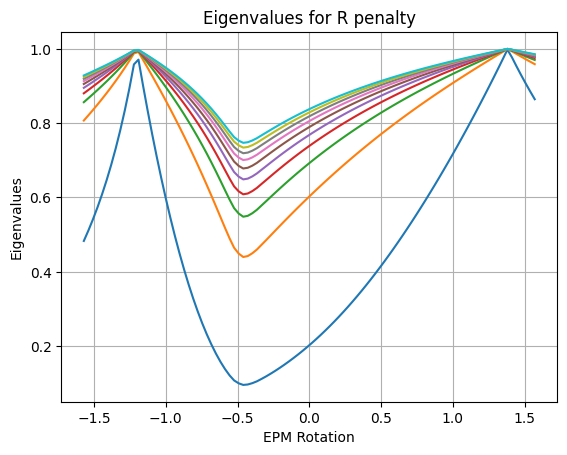

In [464]:
plt.figure()
for pen, y in y_eig_by_pen.items():
    plt.plot(psi_list, y, label=f"Penalty: {pen}")
plt.xlabel("EPM Rotation")
plt.ylabel("Eigenvalues")
plt.title("Eigenvalues for R penalty")
plt.grid()
# plt.legend()
plt.show()

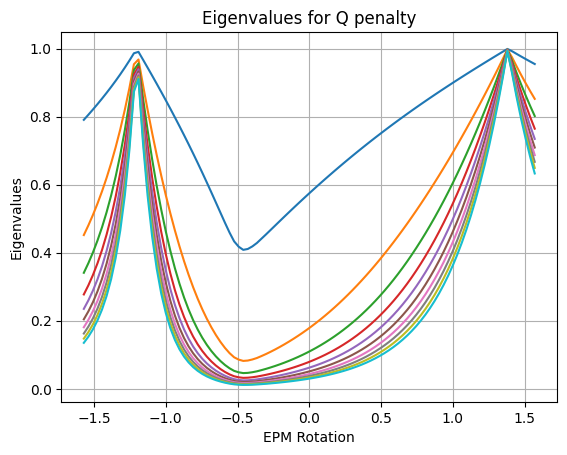

In [462]:
plt.figure()
for pen, y in y_eig_by_pen.items():
    plt.plot(psi_list, y, label=f"Penalty: {pen}")
plt.xlabel("EPM Rotation")
plt.ylabel("Eigenvalues")
plt.title("Eigenvalues for Q penalty")
plt.grid()
# plt.legend()
plt.show()

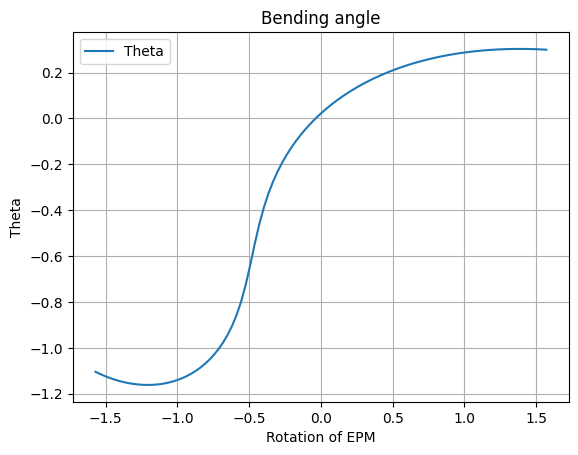

In [449]:
plt.figure()
plt.plot(psi_list, theta_values, label="Theta")
plt.legend()
plt.grid()
plt.xlabel("Rotation of EPM")
plt.ylabel("Theta")
plt.title("Bending angle")
plt.show()

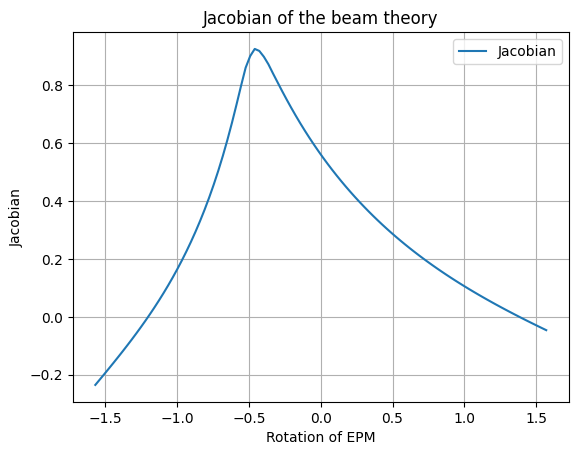

In [450]:
plt.figure()
plt.plot(psi_list, jac_values, label="Jacobian")
plt.legend()
plt.grid()
plt.xlabel("Rotation of EPM")
plt.ylabel("Jacobian")
plt.title("Jacobian of the beam theory")
plt.show()

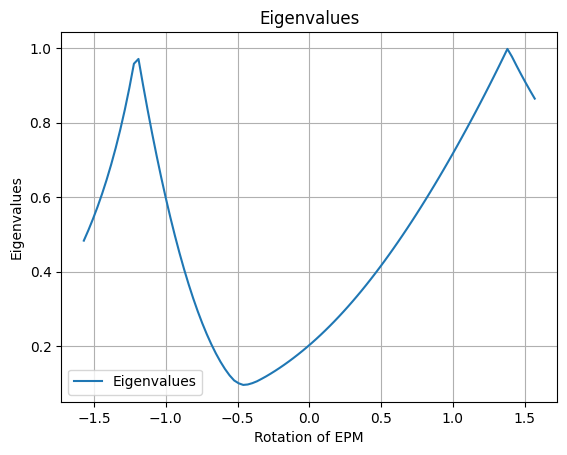

In [451]:
plt.figure()
plt.plot(psi_list, eigen_values, label="Eigenvalues")
plt.legend()
plt.grid()
plt.xlabel("Rotation of EPM")
plt.ylabel("Eigenvalues")
plt.title("Eigenvalues")
plt.show()

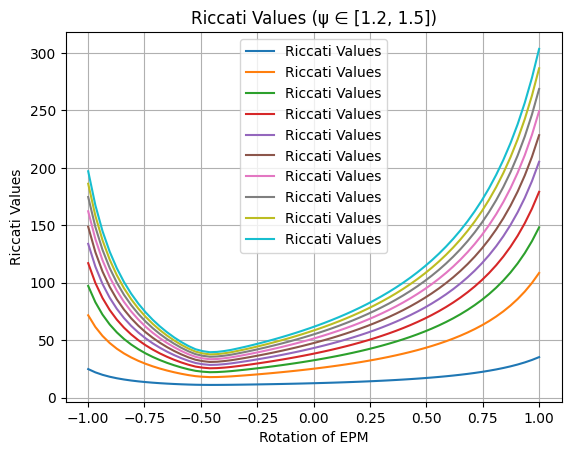

In [489]:
psi = np.asarray(psi_list)
mask = (psi>=-1)& (psi<=1.0)
plt.figure()
for pen, y in y_P_by_pen.items():
    plt.plot(psi_list[mask], y[mask], label="Riccati Values")
plt.grid(); plt.legend()
plt.xlabel("Rotation of EPM"); plt.ylabel("Riccati Values")
plt.title("Riccati Values (ψ ∈ [1.2, 1.5])")
plt.show()


In [490]:
angle = np.rad2deg(1)
angle

np.float64(57.29577951308232)

In [ ]:
# def mpc_step_trust_region_tvQ_from_theta(
#     A, B, Q, R, N, xk, xref_seq, dt, dpsi_max,
#     psi_k, theta_fn, J_fn,
#     A_list=None, B_list=None,     
#     Jmin=1e-6
# ):
#     if (A_list is not None) and (B_list is not None):
#         A_last, B_last = A_list[-1], B_list[-1]
#         Qf = solve_discrete_are(A_last, B_last, Q, R)
#         psi_end = None; J_end = None
#     else:
#         Qf = Q_th
#     # print(f"Penalty term is : {Q_th} and the terminal penalty term is: {Qf}")
#     M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
#     H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)

#     S = np.tril(np.ones((N, N), float)) * dt
#     l = -np.ones(N) * dpsi_max
#     u = +np.ones(N) * dpsi_max
#     U, y = solve_qp_osqp(H, F, S, l, u)

#     X_pred = M @ xk + C @ U
#     return U, X_pred, (Qf, psi_end, J_end, H, F, M, C, Qtil, S, (l, u), y)

In [ ]:
def mpc_step_trust_region_tvQ_from_theta(
    A, B, Q, R, N, xk, xref_seq, dt, dpsi_max,
    psi_k, theta_fn, J_fn,
    A_list=None, B_list=None,     
    Jmin=1e-6,
    idx_theta=0,                
    error_threshold=10      
):
    if (A_list is not None) and (B_list is not None):
        A_last, B_last = A_list[-1], B_list[-1]
        Qf = solve_discrete_are(A_last, B_last, Q, R)
     
    else:
        Qf = Q_th

    M, C, Qtil, Rtil = mpc_stack(A, B, Q, R, Qf, N)
    H, F = mpc_cost(M, C, Qtil, Rtil, xk, xref_seq)


    S = np.tril(np.ones((N, N), float)) * dt
    l_s = -np.ones(N) * dpsi_max
    u_s = +np.ones(N) * dpsi_max

    nx = A.shape[0]
    e_theta = np.zeros((1, nx)); e_theta[0, idx_theta] = 1.0
    E = np.kron(np.eye(N), e_theta)          


    theta_ref = np.asarray(xref_seq).reshape(N)
    band = np.deg2rad(error_threshold)
    EMx = E @ (M @ xk)                        

    A_theta = E @ C                        
    rhs_pos = theta_ref + band - EMx                
    rhs_neg = -theta_ref + band + EMx               

    A_osqp = np.vstack([ S,       
                         A_theta,     
                         -A_theta ])  
    l_osqp = np.concatenate([ l_s,
                              -np.inf*np.ones(N),
                              -np.inf*np.ones(N) ])
    u_osqp = np.concatenate([ u_s,
                              rhs_pos,
                              rhs_neg ])

    U, y, status = solve_qp_osqp(H, F, A_osqp, l_osqp, u_osqp)
    X_pred = M @ xk + C @ U if U is not None else None
    return U, X_pred, (Qf, None, None, H, F, M, C, Qtil, A_osqp, (l_osqp, u_osqp), y, status)



In [ ]:
def mpc_compare_logged3(ref, T, dt, p_vec, *,
                       Np=15, w_th=1.0, w_u=1e-3,
                       psi0_rad=0.0, J_min=1e-5, s_steps=10,
                       eps_theta_deg=10.0, h_deg_for_radius=0.5, sigma_theta_meas_deg=0.2, error_threshold=10):

    S = np.tril(np.ones((Np, Np), float)) * dt
    rng = np.random.default_rng(2)
    sigma_theta_meas = np.deg2rad(sigma_theta_meas_deg)

    log = dict(
        t=[], theta_ref_deg=[],

        psi_free_deg=[], u_free_deg_s=[], theta0_free_deg=[], theta_pred_free_k1_deg=[],
        psi_tr_deg=[],   u_tr_deg_s=[],   theta0_tr_deg=[],   theta_pred_tr_k1_deg=[],

        dpsi_max_deg=[], viol_free_deg=[], viol_tr_deg=[], du0_deg_s=[],
        active_upper_cnt=[], active_lower_cnt=[],

        theta_true_next_free_deg=[], theta_true_next_tr_deg=[],
        e_traj_free_deg=[], e_traj_tr_deg=[],
        se_traj_free_deg2=[], se_traj_tr_deg2=[],
    )

    psi_free = float(psi0_rad)
    psi_tr   = float(psi0_rad)

    N = int(round(T/dt))
    for k in range(N):
        t = k*dt

        psi_k_free = psi_free
        theta0_free   = float(theta_fn(np.rad2deg(psi_k_free)))
        theta0_free_n = float(theta0_free + rng.normal(0.0, sigma_theta_meas))
        J0_free       = float(J_fn(psi_k_free))
        # theta_tip, k_star, sol_ivp, info = simulate_beam(
        #     p_vec=p_vec,
        #     psi_deg=np.rad2deg(psi_k_free),
        #     L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        #     MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        #     s_steps=200
        # )
        # _, J_tip, _ = jacobian_tip_from_sim2(
        #     p_vec, psi_k_free, L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        #     MU0=MU0, MAGNET_M=MAGNET_M, m_line_of_s=m_line_of_s,
        #     GRAD_SCALE=1.0, s_steps=400
        # )

        # print(f"ψ={np.degrees(psi_k_free):.3f}° | θ_fit={np.degrees(theta0_free):.3f}° "
        #     f"| θ_true={np.degrees(theta_tip):.3f}° | J_fit={J0_free:.4f} | J_true={J_tip:.4f}")


        A_th = np.array([[1.0]])
        B_th_free = np.array([[max(abs(J0_free), J_min) * np.sign(J0_free) * dt]])        
        Q_th = np.array([[w_th]]); R_u = np.array([[w_u]]); Qf_th = Q_th

        xk_free = np.array([theta0_free_n])
        xref = np.array([ref(t + (i+1)*dt)[0] for i in range(Np)], float)

        U_free, X_free, _ = mpc_step_unconstrained(A_th, B_th_free, Q_th, R_u, Qf_th, Np, xk_free, xref)
        u0_free = float(np.ravel(U_free)[0])
        ANGLE_LIM = 0.5*np.pi  # = pi/2
        u_min = (-ANGLE_LIM - psi_free) / dt
        u_max = ( +ANGLE_LIM - psi_free) / dt
        u0_free = np.clip(u0_free, u_min, u_max)
        psi_free_next = psi_free + u0_free*dt


        psi_k_tr = psi_tr
        theta0_tr   = float(theta_fn(np.degrees(psi_k_tr)))
        theta0_tr_n = float(theta0_tr + rng.normal(0.0, sigma_theta_meas))
        J0_tr       = float(J_fn(psi_k_tr))
        B_th_tr = np.array([[max(abs(J0_tr), J_min) * np.sign(J0_tr) * dt]])        
        xk_tr = np.array([theta0_tr_n])
        # psi_nom = np.full(Np, psi_tr)  
        # A_list = [np.array([[1.0]]) for _ in range(Np)]
        # B_list = [np.array([[dt * float(J_fn(psi_nom[k]))]]) for k in range(Np)]

        eps_theta_rad = np.deg2rad(eps_theta_deg)
        dpsi_max, diag = trust_radius(lambda ψ: float(J_fn(ψ)),
                                    psi_k_tr,
                                    h_rad=np.deg2rad(h_deg_for_radius),
                                    eps_theta_rad=np.deg2rad(eps_theta_deg),
                                    Jmin=1e-6, Lmin=1e-6, dpsi_cap=np.deg2rad(5.0))

        if 'U_prev' not in locals():
            U_prev = np.zeros(Np)                  
        U_nom = np.r_[U_prev[1:], U_prev[-1]]  
        psi_nom = psi_tr + (S @ U_nom)            

        A_list = [np.array([[1.0]]) for _ in range(Np)]
        B_list = [np.array([[dt * float(J_fn(psi_nom[k]))]]) for k in range(Np)]
        # print(dpsi_max)
        U_tr, X_tr, tr_pack = mpc_step_trust_region_tvQ_from_theta(
            A_th, B_th_tr, Q_th, R_u, Np, xk_tr, xref, dt, dpsi_max,
            psi_k_tr, theta_fn, J_fn, A_list, B_list, Jmin=1e-6, error_threshold=error_threshold)

        status = tr_pack[-1]
        is_infeas = (status not in ("solved", "solved inaccurate"))
        log.setdefault("qp_status", []).append(1 if is_infeas else 0)

        if is_infeas or (U_tr is None) or (X_tr is None):
            u0_tr = 0.0
            psi_tr_next = psi_tr
            U_prev = np.zeros(Np)
            U_tr_vec = np.zeros(Np)         
        else:
            u0_tr = float(np.ravel(U_tr)[0])
            psi_tr_next = psi_tr + u0_tr*dt
            U_prev = np.asarray(U_tr, float).reshape(-1)
            U_tr_vec = U_prev                  

        U_free_vec = np.asarray(U_free, float).reshape(-1) 
        viol_free  = float(np.max(np.abs(S @ U_free_vec)))
        viol_tr    = float(np.max(np.abs(S @ U_tr_vec)))


        if X_tr is None:
            theta_pred_tr_k1_deg = np.nan
        else:
            theta_pred_tr_k1_deg = np.degrees(float(np.ravel(X_tr)[0]))

        # U_prev = np.asarray(U_tr, float).reshape(-1)

        # u0_tr = float(np.ravel(U_tr)[0])
        # psi_tr_next = psi_tr + u0_tr*dt

        # U_free_vec = np.asarray(U_free, float).reshape(-1)
        # U_tr_vec   = np.asarray(U_tr,   float).reshape(-1)
        # viol_free  = float(np.max(np.abs(S @ U_free_vec)))
        # viol_tr    = float(np.max(np.abs(S @ U_tr_vec)))

        theta_true_next_free = float(theta_fn(np.degrees(psi_free_next)))
        theta_true_next_tr   = float(theta_fn(np.degrees(psi_tr_next)))

        log["t"].append(t)
        log["theta_ref_deg"].append(np.degrees(xref[0]))

        log["psi_free_deg"].append(np.degrees(psi_free))
        log["u_free_deg_s"].append(np.degrees(u0_free))
        log["theta0_free_deg"].append(np.degrees(theta0_free))
        log["theta_pred_free_k1_deg"].append(np.degrees(float(np.ravel(X_free)[0])))

        log["psi_tr_deg"].append(np.degrees(psi_tr))
        log["u_tr_deg_s"].append(np.degrees(u0_tr))
        log["theta0_tr_deg"].append(np.degrees(theta0_tr))
        log["theta_pred_tr_k1_deg"].append(theta_pred_tr_k1_deg)

        log["dpsi_max_deg"].append(np.degrees(dpsi_max))
        log["viol_free_deg"].append(np.degrees(viol_free))
        log["viol_tr_deg"].append(np.degrees(viol_tr))
        log["du0_deg_s"].append(np.degrees(u0_tr - u0_free))

        # y_dual = tr_pack[-2]  # duals vector from OSQP
        # log["active_upper_cnt"].append(int(np.sum(y_dual > +1e-6)))
        # log["active_lower_cnt"].append(int(np.sum(y_dual < -1e-6)))

        log["theta_true_next_free_deg"].append(np.degrees(theta_true_next_free))
        log["theta_true_next_tr_deg"].append(np.degrees(theta_true_next_tr))
        e_free = log["theta_true_next_free_deg"][-1] - log["theta_ref_deg"][-1]
        e_tr   = log["theta_true_next_tr_deg"][-1]   - log["theta_ref_deg"][-1]

        log["e_traj_free_deg"].append(e_free)
        log["e_traj_tr_deg"].append(e_tr)
        log["se_traj_free_deg2"].append(e_free**2)
        log["se_traj_tr_deg2"].append(e_tr**2)
        psi_free = psi_free_next
        psi_tr   = psi_tr_next

    for k in list(log.keys()):
        if k not in ("Np","dt"):
            log[k] = np.asarray(log[k], float)

    log["rmse_traj_free_deg"] = float(np.sqrt(np.mean(log["se_traj_free_deg2"]))) if log["se_traj_free_deg2"].size else np.nan
    log["rmse_traj_tr_deg"]   = float(np.sqrt(np.mean(log["se_traj_tr_deg2"])))   if log["se_traj_tr_deg2"].size   else np.nan

    log["Np"] = Np; log["dt"] = dt
    return log



In [962]:
def pd_controller(psi_up, ref_traj, time, dt, gain, kp, kd):
    t_hist, u_hist, err_hist, delt_u_hist, theta_hist, ref_hist = [], [], [], [], [], []

    e_int = 0.0
    prev_error = 0.0
    prev_theta = None         
    d_filt = 0.0
    alpha = dt / (0.2 + dt)

    N = int(time/dt)
    for k in range(N):
        t = k*dt
        # if k%(N//10) == 0:
        #     print(f"Progress: {100*k//N}% done")
        if callable(ref_traj):
            theta_ref, _ = ref_traj(t)
        else:
            theta_ref, _ = ref_traj

        # theta_real, _, _, _ = simulate_beam(
        #     p_vec, psi_up,
        #     L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        #     MU0=MU0, MAGNET_M=MAGNET_M,
        #     m_line_of_s=m_line_of_s,
        #     s_steps=200
        # )

        theta_real = float(theta_fn(np.rad2deg(psi_up)))
        error = theta_ref - theta_real

        if prev_theta is None:
            d_meas = 0.0
        else:
            d_meas = -(theta_real - prev_theta) / dt 
        prev_theta = theta_real

        d_term = (1 - alpha) * d_filt + alpha * d_meas
        d_filt = d_term

        delta_psi = gain * (kp * error + kd * d_term)
        psi_up += delta_psi

        # logs
        t_hist.append(t)
        u_hist.append(psi_up)
        err_hist.append(error)
        delt_u_hist.append(delta_psi)
        theta_hist.append(theta_real)
        ref_hist.append(theta_ref)

    return dict(
        t=np.array(t_hist),
        theta_rad=np.array(theta_hist),
        theta_ref=np.array(ref_hist),
        psi_rad=np.array(u_hist),
        error_rad=np.array(err_hist),
        u_up=np.array(delt_u_hist),
    )


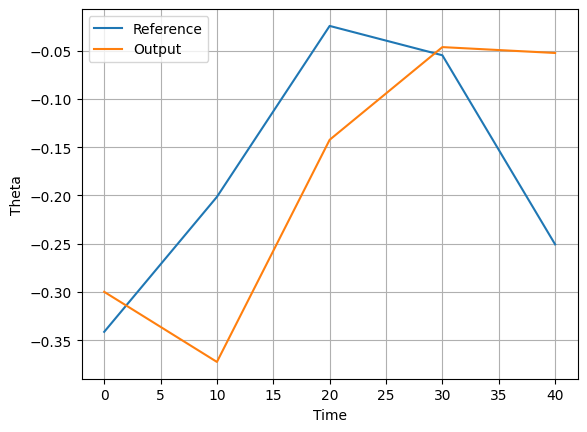

MSE = 1.683536e-02 rad^2  (55.267 deg^2),   RMSE = 7.434 deg


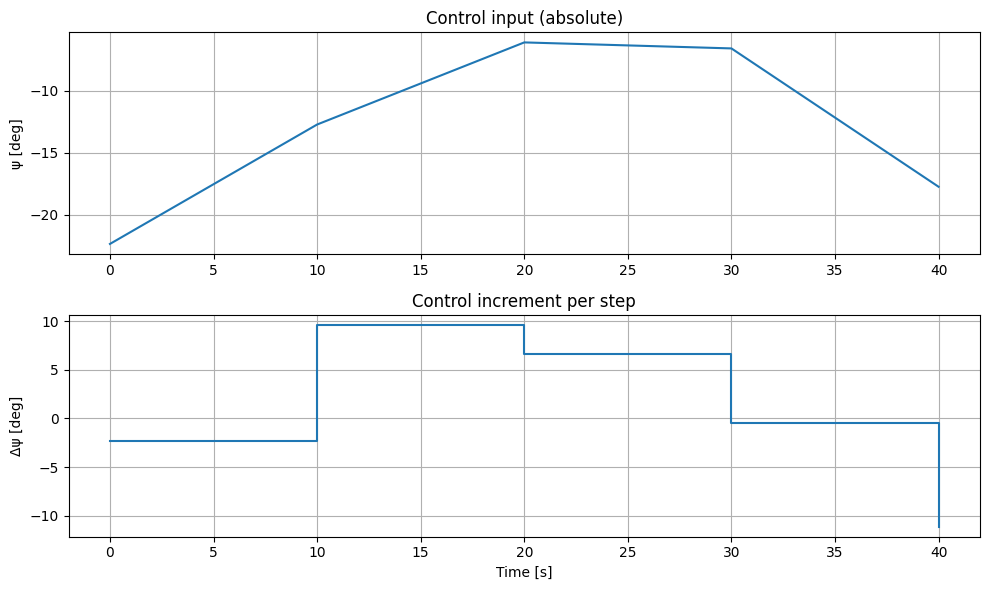

In [ ]:
gain = 1.4
kp = 0.7
kd = 0.01
psi0 = np.deg2rad(-20)
test_pd_control = pd_controller(psi0, ref, time, dt, gain, kp, kd)
t_plot = test_pd_control["t"]
ref_plot = test_pd_control["theta_ref"]
actual_plot = test_pd_control["theta_rad"]
plt.figure()
plt.plot(t_plot, ref_plot, label = "Reference")
plt.plot(t_plot, actual_plot, label = "Output")
plt.grid(True)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Theta")
plt.show()
mse_rad = float(np.mean((actual_plot - ref_plot)**2))
mse_deg = float(np.mean((np.rad2deg(actual_plot - ref_plot))**2))
rmse_deg = mse_deg**0.5
print(f"MSE = {mse_rad:.6e} rad^2  ({mse_deg:.3f} deg^2),   RMSE = {rmse_deg:.3f} deg")

psi_deg   = np.rad2deg(test_pd_control["psi_rad"])  # absolute input ψ(t)
dpsi_deg  = np.rad2deg(test_pd_control["u_up"])     # per-step change Δψ

plt.figure(figsize=(10,6))
ax1 = plt.subplot(2,1,1)
ax1.plot(t_plot, psi_deg)
ax1.set_title("Control input (absolute)")
ax1.set_ylabel("ψ [deg]")
ax1.grid(True)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.step(t_plot, dpsi_deg, where="post")
ax2.set_title("Control increment per step")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Δψ [deg]")
ax2.grid(True)

plt.tight_layout()
plt.show()


In [1197]:
dt=0.5
error_threshold = np.inf
eps_theta_deg=25.0
sigma_theta_meas_deg=0

In [ ]:
import numpy as np

def freeze_reference(ref_callable, time, dt_ref):
    t_ref = np.arange(0.0, time + 1e-12, dt_ref)
    theta_ref = np.array([ref_callable(t)[0] for t in t_ref])      # radians
    dtheta_ref = np.gradient(theta_ref, dt_ref)

    def ref_interp(t):
        th = np.interp(t, t_ref, theta_ref, left=theta_ref[0], right=theta_ref[-1])
        dth = np.interp(t, t_ref, dtheta_ref, left=dtheta_ref[0], right=dtheta_ref[-1])
        return float(th), float(dth)

    return ref_interp


In [ ]:
gain = 1.4
kp = 0.7
kd = 0.01
psi0 = np.deg2rad(0)
dt_ref = dt       
ref_fixed = freeze_reference(ref, time, dt_ref)

dt_ctrl = dt          
test_pd_control = pd_controller(psi0, ref_fixed, time, dt_ctrl, gain, kp, kd)

t_plot      = test_pd_control["t"]
ref_plot    = test_pd_control["theta_ref"]
actual_plot = test_pd_control["theta_rad"]

mse_rad  = float(np.mean((actual_plot - ref_plot)**2))
mse_deg  = float(np.mean((np.rad2deg(actual_plot - ref_plot))**2))
rmse_deg = mse_deg**0.5
print(f"MSE = {mse_rad:.6e} rad^2  ({mse_deg:.3f} deg^2),   RMSE = {rmse_deg:.3f} deg")

theta_PD_deg      = np.rad2deg(actual_plot)
theta_ref_PD_deg  = np.rad2deg(ref_plot)  
psi_PD_deg        = np.rad2deg(test_pd_control["psi_rad"])
u_PD_deg_per_s    = np.rad2deg(test_pd_control["u_up"]) / dt  


MSE = 3.058678e-03 rad^2  (10.041 deg^2),   RMSE = 3.169 deg


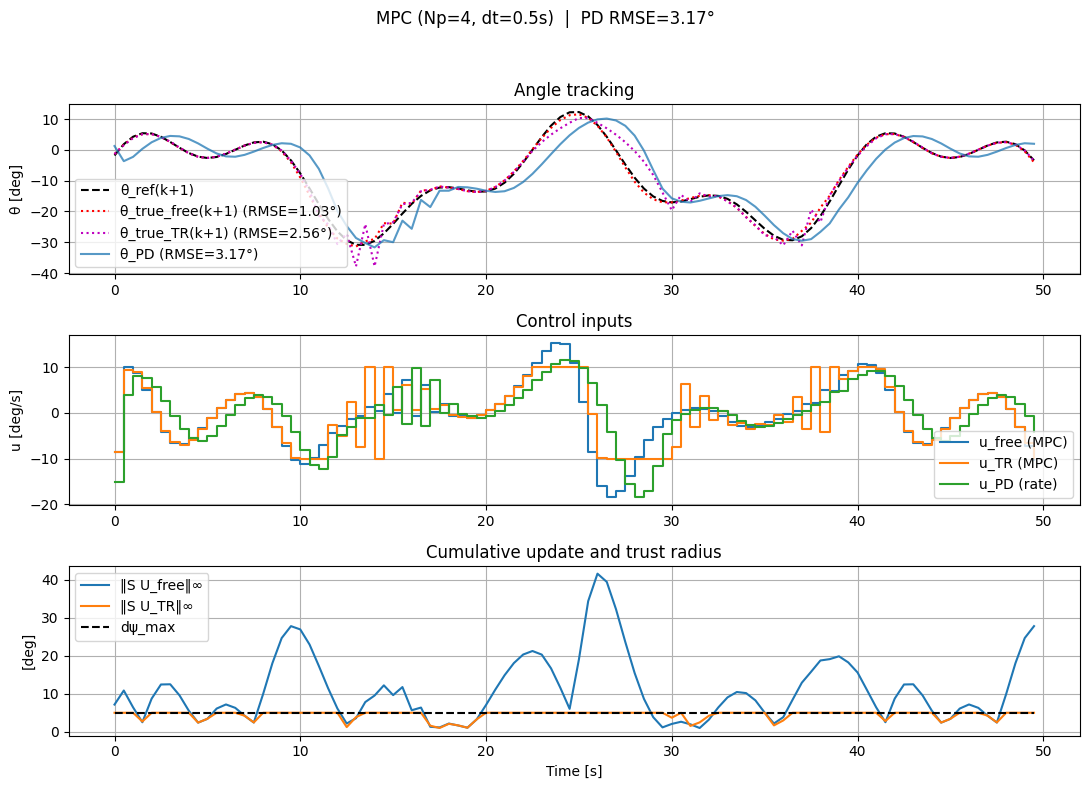

In [ ]:
log = mpc_compare_logged3(ref, T=time, dt=dt, p_vec=p_vec,
                          Np=4, w_th=100.0, w_u=1.0,
                          psi0_rad=np.deg2rad(0), J_min=1e-5,
                          s_steps=10, eps_theta_deg=eps_theta_deg,
                          sigma_theta_meas_deg=sigma_theta_meas_deg,
                          error_threshold=error_threshold)

t = log["t"]
qs = np.asarray(log.get("qp_status", np.zeros_like(t))).astype(bool)
qs = qs[:len(t)]

plt.figure(figsize=(11,8))
plt.suptitle(f"MPC (Np={int(log['Np'])}, dt={log['dt']:.3g}s)  |  PD RMSE={rmse_deg:.2f}°")

ax1 = plt.subplot(3,1,1)
ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label=f"θ_true_free(k+1) (RMSE={log['rmse_traj_free_deg']:.2f}°)")
ax1.plot(t, log["theta_true_next_tr_deg"],  "m:", label=f"θ_true_TR(k+1) (RMSE={log['rmse_traj_tr_deg']:.2f}°)")
# ax1.plot(t, log["theta_pred_free_k1_deg"], label="θ̂_free(k+1)")

ax1.plot(t_plot, theta_PD_deg, label=f"θ_PD (RMSE={rmse_deg:.2f}°)", alpha=0.75)

if np.any(qs):
    ax1.scatter(t[qs], log["theta_true_next_tr_deg"][qs], marker="x", s=80, c="red", label="QP infeasible")
    for tk in t[qs]:
        ax1.axvspan(tk-0.5*dt, tk+0.5*dt, color="red", alpha=0.12)

ax1.set_title("Angle tracking")
ax1.set_ylabel("θ [deg]")
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free (MPC)")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR (MPC)")
ax2.step(t_plot, u_PD_deg_per_s, where="post", label="u_PD (rate)")
ax2.set_title("Control inputs")
ax2.set_ylabel("u [deg/s]")
ax2.grid(True)
ax2.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_title("Cumulative update and trust radius")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("[deg]")
ax3.grid(True)
ax3.legend()

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [1253]:
dt=.5
error_threshold = np.inf
eps_theta_deg=10.0
sigma_theta_meas_deg=5

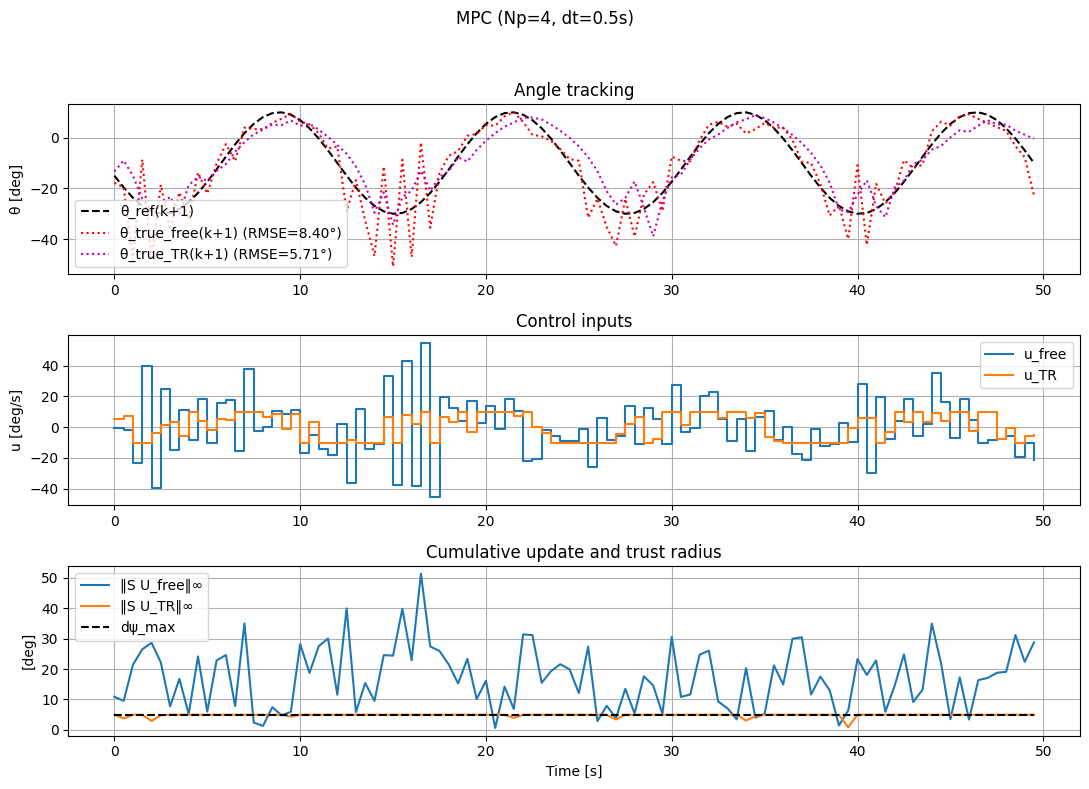

In [1254]:

log = mpc_compare_logged3(ref_sine, T=time, dt=dt, p_vec=p_vec,
                          Np=4, w_th=10.0, w_u=1.0,
                          psi0_rad=np.deg2rad(-20), J_min=1e-5,
                          s_steps=10, eps_theta_deg=eps_theta_deg, sigma_theta_meas_deg=sigma_theta_meas_deg,error_threshold=error_threshold)

t = log["t"]
qs = log.get("qp_status", np.zeros_like(t))
qs = np.asarray(qs).astype(bool)            
qs = qs[:len(t)]                          
mask = qs

plt.figure(figsize=(11,8))
plt.suptitle(f"MPC (Np={int(log['Np'])}, dt={log['dt']:.3g}s)")

ax1 = plt.subplot(3,1,1)
ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label=f"θ_true_free(k+1) (RMSE={log['rmse_traj_free_deg']:.2f}°)")
ax1.plot(t, log["theta_true_next_tr_deg"],  "m:", label=f"θ_true_TR(k+1) (RMSE={log['rmse_traj_tr_deg']:.2f}°)")
# ax1.plot(t, log["theta_pred_free_k1_deg"],       label="θ̂_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],         label="θ̂_TR(k+1)")
if np.any(mask):
    ax1.scatter(t[mask], log["theta_true_next_tr_deg"][mask],
                marker="x", s=80, c="red", label="QP infeasible")
    for tk in t[mask]:
        ax1.axvspan(tk-0.5*dt, tk+0.5*dt, color="red", alpha=0.12)

ax1.set_title("Angle tracking"); ax1.set_ylabel("θ [deg]")
ax1.legend(); ax1.grid(True)

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_title("Control inputs"); ax2.set_ylabel("u [deg/s]")
ax2.grid(True); ax2.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_title("Cumulative update and trust radius")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]")
ax3.legend(); ax3.grid(True)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



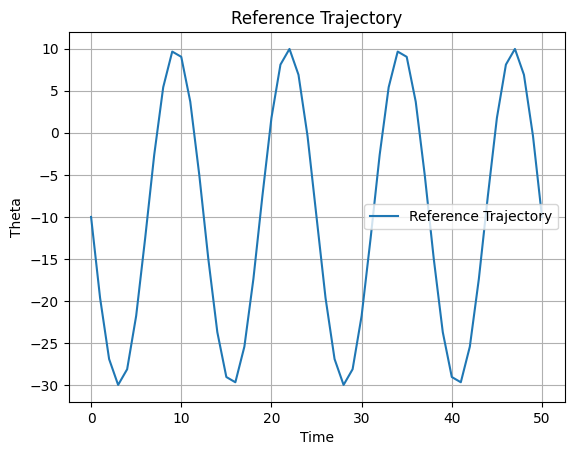

In [1129]:
p_vec = np.array([LENGTH, 0.18, 0.0])
A_deg = np.deg2rad(20)      
f_hz = 0.08
offset_deg = np.deg2rad(-10.0)  
phase_deg = 0.0  
time = 50.0          
dt = 1   
Np = 3   
ref_sine = make_ref_sine(A_deg, f_hz, offset_deg, phase_deg)
t = np.arange(0.0, time+dt, dt)
theta_ref = np.array([ref_sine(test)[0] for test in t])
theta_dot = np.array([ref_sine(test)[1] for test in t])


plt.figure()
plt.plot(t, np.rad2deg(theta_ref), label="Reference Trajectory")
# plt.plot(t, np.rad2deg(theta_dot), label="Derivative of Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Reference Trajectory")
plt.legend()
plt.grid()
plt.show()

In [1092]:
dt=.3
error_threshold = np.inf
eps_theta_deg=10.0
sigma_theta_meas_deg=0

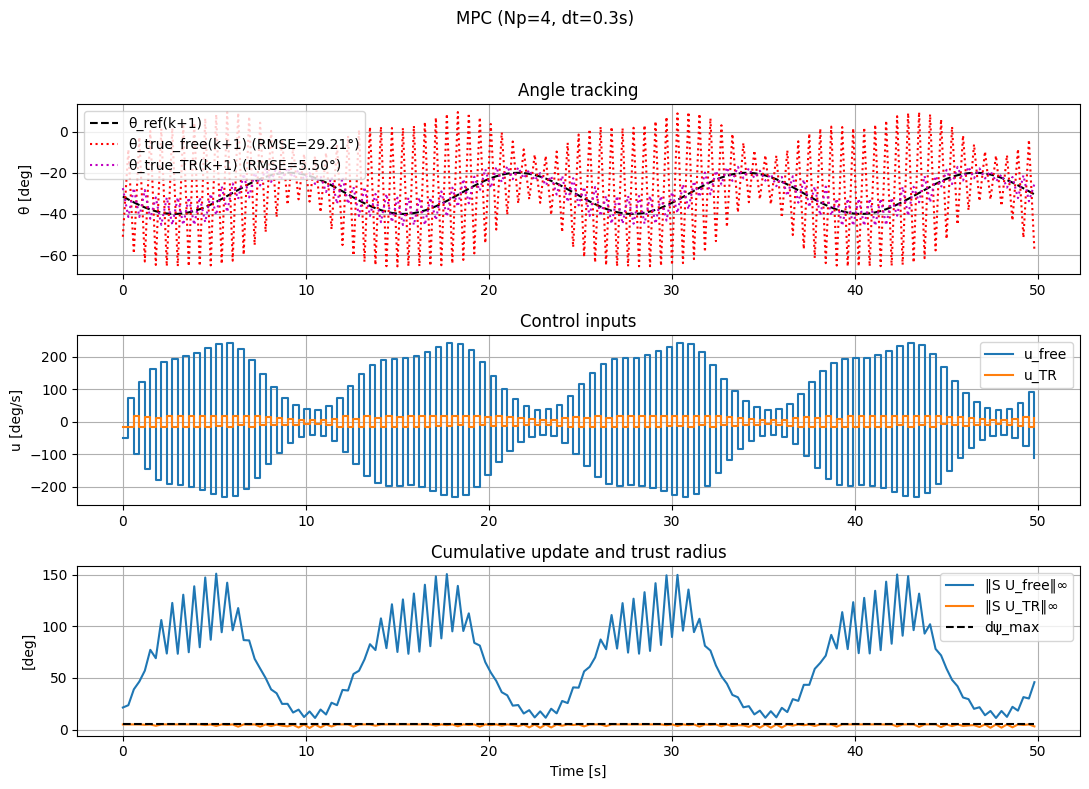

In [1093]:

log = mpc_compare_logged3(ref_sine, T=time, dt=dt, p_vec=p_vec,
                          Np=4, w_th=100.0, w_u=1.0,
                          psi0_rad=np.deg2rad(-20), J_min=1e-5,
                          s_steps=10, eps_theta_deg=eps_theta_deg, sigma_theta_meas_deg=sigma_theta_meas_deg,error_threshold=error_threshold)

t = log["t"]
qs = log.get("qp_status", np.zeros_like(t))
qs = np.asarray(qs).astype(bool)            
qs = qs[:len(t)]                          
mask = qs

plt.figure(figsize=(11,8))
plt.suptitle(f"MPC (Np={int(log['Np'])}, dt={log['dt']:.3g}s)")

ax1 = plt.subplot(3,1,1)
ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref(k+1)")
ax1.plot(t, log["theta_true_next_free_deg"], "r:", label=f"θ_true_free(k+1) (RMSE={log['rmse_traj_free_deg']:.2f}°)")
ax1.plot(t, log["theta_true_next_tr_deg"],  "m:", label=f"θ_true_TR(k+1) (RMSE={log['rmse_traj_tr_deg']:.2f}°)")
# ax1.plot(t, log["theta_pred_free_k1_deg"],       label="θ̂_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],         label="θ̂_TR(k+1)")
# draw infeasible markers AFTER ax1 exists
if np.any(mask):
    ax1.scatter(t[mask], log["theta_true_next_tr_deg"][mask],
                marker="x", s=80, c="red", label="QP infeasible")
    # optional light red shading at infeasible steps
    for tk in t[mask]:
        ax1.axvspan(tk-0.5*dt, tk+0.5*dt, color="red", alpha=0.12)

ax1.set_title("Angle tracking"); ax1.set_ylabel("θ [deg]")
ax1.legend(); ax1.grid(True)

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_title("Control inputs"); ax2.set_ylabel("u [deg/s]")
ax2.grid(True); ax2.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
ax3.set_title("Cumulative update and trust radius")
ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]")
ax3.legend(); ax3.grid(True)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



In [889]:
# θ(ψ) but both in *radians* internally
theta_rad = lambda psi_rad: np.deg2rad(theta_fn(np.rad2deg(psi_rad)))  # in: ψ[rad] -> θ[deg] -> θ[rad]
def J_num_fn(psi):
    h = np.deg2rad(0.1)
    return (theta_rad(psi + h) - theta_rad(psi - h)) / (2*h)

def lin_err(psi0, dpsi):
    return theta_rad(psi0 + dpsi) - (theta_rad(psi0) + J_rad(psi0)*dpsi)

J_rad = lambda psi: J_num_fn(psi)   # convert deg/rad -> rad/rad

psi0_rad = np.deg2rad(45.0)
h_rad    = np.deg2rad(0.1)                 # small probe (~0.1°)
dpsis    = np.array([5e-2, 2e-2, 1e-2, 5e-3, 2e-3])  # radians
h = np.deg2rad(0.1)
J_num = (theta_rad(psi0_rad + h) - theta_rad(psi0_rad - h)) / (2*h)
s = float(J_num / J_rad(psi0_rad))
J_cal = lambda psi: s * J_rad(psi)
errs  = np.abs([lin_err(psi0_rad, d) for d in dpsis])
p     = np.polyfit(np.log(dpsis), np.log(errs), 1)[0]
print("empirical slope ~", p)              # expect ~ 2

ratios = errs / (dpsis**2)
print("err / dpsi^2 →", ratios[-1])        # should → 0.5*|θ''(ψ0)|

# curvature estimate (two equivalent ways)
half_theta_pp_from_J = 0.5 * abs((J_rad(psi0_rad + h_rad) - J_rad(psi0_rad - h_rad)) / (2*h_rad))
print("0.5*|θ''(ψ0)| ≈", half_theta_pp_from_J)

# sanity: does your analytic J match the numeric derivative?
J_num = (theta_rad(psi0_rad + h_rad) - theta_rad(psi0_rad - h_rad)) / (2*h_rad)
print("J_rad vs J_num:", J_rad(psi0_rad), J_num)



empirical slope ~ 2.00708392388958
err / dpsi^2 → 0.0024712069667063435
0.5*|θ''(ψ0)| ≈ 0.002469800546379423
J_rad vs J_num: 0.0024790396082910423 0.0024790396082910423


In [ ]:
theta_rad = lambda psi: np.deg2rad(theta_fn(np.rad2deg(psi)))

h = np.deg2rad(0.5)
J_num = (theta_rad(psi0_rad + h) - theta_rad(psi0_rad - h)) / (2*h) 
J_raw = J_fn(psi0_rad)                                             

print("Numerical J (rad/rad):", J_num)
print("Raw J_fn:", J_raw)
print("Scale needed s = J_num / J_raw:", J_num / J_raw)


Numerical J (rad/rad): 0.0024788365713378823
Raw J_fn: 0.17569831937000543
Scale needed s = J_num / J_raw: 0.014108481971974172


In [1233]:
dt=0.5
error_threshold = 17
eps_theta_deg=10.0
sigma_theta_meas_deg=0

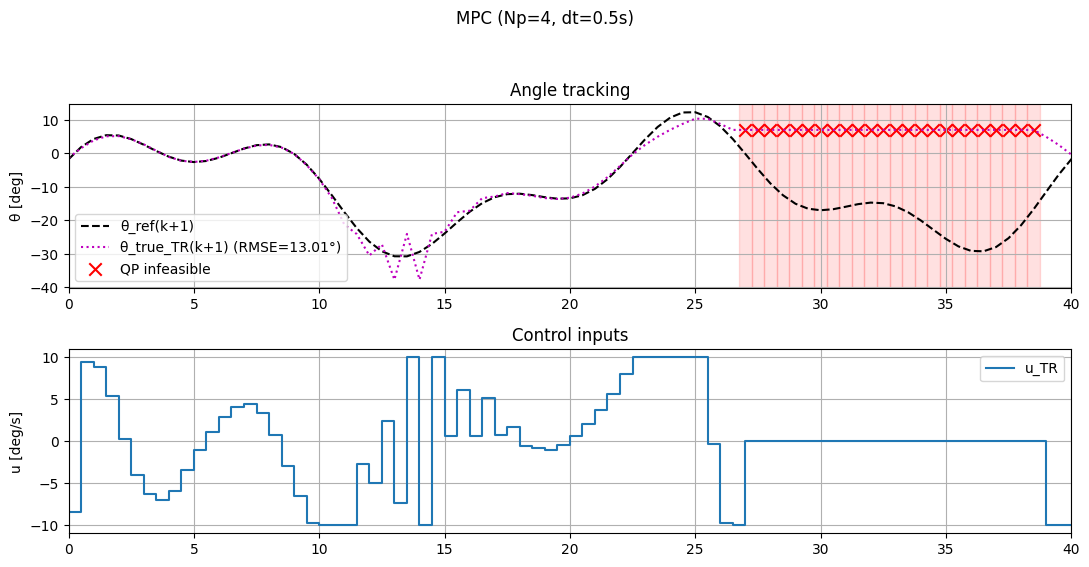

In [1235]:

log = mpc_compare_logged3(ref, T=time, dt=dt, p_vec=p_vec,
                          Np=4, w_th=100.0, w_u=1.0,
                          psi0_rad=np.deg2rad(0), J_min=1e-5,
                          s_steps=10, eps_theta_deg=eps_theta_deg, sigma_theta_meas_deg=sigma_theta_meas_deg,error_threshold=error_threshold)

t = log["t"]
qs = log.get("qp_status", np.zeros_like(t))
qs = np.asarray(qs).astype(bool)            
qs = qs[:len(t)]                          
mask = qs

plt.figure(figsize=(11,8))
plt.suptitle(f"MPC (Np={int(log['Np'])}, dt={log['dt']:.3g}s)")

ax1 = plt.subplot(3,1,1)
ax1.plot(t, log["theta_ref_deg"], "k--", label="θ_ref(k+1)")
# ax1.plot(t, log["theta_true_next_free_deg"], "r:", label=f"θ_true_free(k+1) (RMSE={log['rmse_traj_free_deg']:.2f}°)")
ax1.plot(t, log["theta_true_next_tr_deg"],  "m:", label=f"θ_true_TR(k+1) (RMSE={log['rmse_traj_tr_deg']:.2f}°)")
# ax1.plot(t, log["theta_pred_free_k1_deg"],       label="θ̂_free(k+1)")
# ax1.plot(t, log["theta_pred_tr_k1_deg"],         label="θ̂_TR(k+1)")
if np.any(mask):
    ax1.scatter(t[mask], log["theta_true_next_tr_deg"][mask],
                marker="x", s=80, c="red", label="QP infeasible")
    for tk in t[mask]:
        ax1.axvspan(tk-0.5*dt, tk+0.5*dt, color="red", alpha=0.12)
ax1.set_xlim(0,40)
ax1.set_title("Angle tracking"); ax1.set_ylabel("θ [deg]")
ax1.legend(); ax1.grid(True)

ax2 = plt.subplot(3,1,2, sharex=ax1)
# ax2.step(t, log["u_free_deg_s"], where="post", label="u_free")
ax2.step(t, log["u_tr_deg_s"],   where="post", label="u_TR")
ax2.set_title("Control inputs"); ax2.set_ylabel("u [deg/s]")
ax2.grid(True); ax2.legend()

# ax3 = plt.subplot(3,1,3, sharex=ax1)
# ax3.plot(t, log["viol_free_deg"], label="‖S U_free‖∞")
# ax3.plot(t, log["viol_tr_deg"],   label="‖S U_TR‖∞")
# ax3.plot(t, log["dpsi_max_deg"],  "k--", label="dψ_max")
# ax3.set_title("Cumulative update and trust radius")
# ax3.set_xlabel("Time [s]"); ax3.set_ylabel("[deg]")
# ax3.legend(); ax3.grid(True)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

